In [83]:
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)
random.seed(42)

# Parâmetros globais
N = 8  # Tamanho do tabuleiro (N x N)
POPULATION_SIZE = 50  # Tamanho da população
MAX_GENERATIONS = 200  # Número máximo de gerações do algoritmo genético
MAX_SIM_ITERATIONS = 500  # Número máximo de iterações na simulação evolutiva
MUTATION_RATE = 0.001  # Taxa de mutação
ELITISM_RATE = 0.00001  # Taxa de elitismo
CONVERGENCE_THRESHOLD = 1e-9  # Limiar para convergência
BURNOUT_THRESHOLD = 0.9  # Limiar para burnout

data_records = []  # Lista para armazenar todos os registros

In [5]:
def calculate_conflicts(board):
    conflicts = 0
    for i in range(N):
        for j in range(i + 1, N):
            if board[i] == board[j] or abs(board[i] - board[j]) == abs(i - j):
                conflicts += 1
    return conflicts

def calculate_income(board, university_investment):
    income = 0
    
    # Rendimento objetivo: ausência de conflitos
    for i in range(N):
        if all(board[i] != board[j] and abs(board[i] - board[j]) != abs(i - j) for j in range(N) if j != i):
            income += 1 + university_investment  # Investimento aumenta rendimento imediato
    
    # Rendimento potencial: redução de conflitos futuros
    for i in range(N - 1):
        if board[i] != board[i + 1] and abs(board[i] - board[i + 1]) != 1:
            income += 0.5 + university_investment  # Investimento melhora rendimento potencial
    
    # Rendimento futuro: oportunidades de crescimento
    future_income = sum(1 for i in range(N) if not any(
        board[i] == board[j] or abs(board[i] - board[j]) == abs(i - j) for j in range(N) if j != i
    ))
    income += future_income * university_investment  # Investimento amplifica ganhos futuros
    
    return max(income, 0)

def calculate_cost(board, university_investment, university_support):
    cost = 0
    
    # Custo objetivo: número de conflitos
    conflicts = calculate_conflicts(board)
    cost += conflicts * (1 - university_investment)  # Investimento reduz custos objetivos
    
    # Custo potencial: dificuldade de ajuste (inversamente proporcional ao rendimento)
    potential_cost = max(0, N - calculate_income(board, university_investment))
    cost += potential_cost
    
    # Custo futuro: probabilidade de conflitos futuros
    future_cost = sum(1 for i in range(N) if any(
        board[i] == board[j] or abs(board[i] - board[j]) == abs(i - j) for j in range(N) if j != i
    ))
    future_cost *= (1 - university_support)  # Suporte reduz custos futuros
    cost += future_cost * 0.1
    
    # Penalidade inversa ao suporte
    penalty = 1 / university_support if university_support > 0 else float('inf')  # Evitar divisão por zero
    cost = cost * (1 + penalty) * (1 - university_investment)  # Investimento reduz penalidades
    
    return max(cost, 0)

def is_burnout(cost, income):
    return cost > BURNOUT_THRESHOLD * income

def update_probabilities(probabilities, profit_losses):
    new_probabilities = np.zeros((N, N))
    for col in range(N):
        # Evitar valores negativos em profit_losses
        adjusted_profit_losses = np.maximum(profit_losses[col], 0)  # Substitui valores negativos por 0
        total_profit_loss = np.sum(adjusted_profit_losses)

        if total_profit_loss == 0:  # Caso todos os valores sejam zero
            new_probabilities[col] = probabilities[col]  # Mantém as probabilidades anteriores
        else:
            for row in range(N):
                # Atualiza probabilidade com base no desempenho relativo
                new_probabilities[col][row] = probabilities[col][row] * (adjusted_profit_losses[row] / total_profit_loss)
        
        # Normalizar as probabilidades para garantir que somem 1
        new_probabilities[col] /= np.sum(new_probabilities[col])
    
    return new_probabilities

def evolutionary_simulation(generation, board, university_support, university_investment):
    probabilities = np.ones((N, N)) / N
    last_board = None

    for iteration in range(MAX_SIM_ITERATIONS):
        board = [np.random.choice(N, p=probabilities[col]) for col in range(N)]
        income = calculate_income(board, university_investment)
        cost = calculate_cost(board, university_investment, university_support)

        if is_burnout(cost, income):
            data_records.append({
                "iteration": iteration,
                "board": board,
                "university_support": university_support,
                "university_investment": university_investment,
                "income": income,
                "cost": cost,
                "profit_loss": -1,
                "generation": generation,
                "burnout": True
            })
            return -1  # Penalidade para burnout

        profit_losses = np.zeros((N, N))
        for col in range(N):
            for row in range(N):
                temp_board = board.copy()
                temp_board[col] = row
                temp_income = calculate_income(temp_board, university_investment)
                temp_cost = calculate_cost(temp_board, university_investment, university_support)
                profit_losses[col][row] = temp_income - temp_cost

        new_probabilities = update_probabilities(probabilities, profit_losses)
        if np.allclose(probabilities, new_probabilities, atol=CONVERGENCE_THRESHOLD):
            data_records.append({
                "iteration": iteration,
                "board": board,
                "university_support": university_support,
                "university_investment": university_investment,
                "income": income,
                "cost": cost,
                "profit_loss": profit_losses.sum(),
                "generation": generation,
                "burnout": False
            })
            break

        probabilities = new_probabilities
        last_board = board

        data_records.append({
            "iteration": iteration,
            "board": board,
            "university_support": university_support,
            "university_investment": university_investment,
            "income": income,
            "cost": cost,
            "profit_loss": profit_losses.sum(),
            "generation": generation,
            "burnout": False
        })

    final_income = calculate_income(last_board, university_investment)
    final_cost = calculate_cost(last_board, university_investment, university_support)
    return final_income - final_cost  # Ganho líquido como fitness

In [6]:
def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        board = np.random.permutation(N).tolist()  # Configuração inicial aleatória
        university_support = random.uniform(0.1, 0.75)  # Suporte aleatório
        university_investment = random.uniform(0.1, 0.75)  # Investimento aleatório
        population.append((board, university_support, university_investment))
    return population

def fitness(individual, generation):
    board, university_support, university_investment = individual
    return evolutionary_simulation(generation, board, university_support, university_investment)

def selection(population, fitness_scores):
    selected = []
    for _ in range(len(population)):
        candidates = random.sample(list(zip(population, fitness_scores)), 2)
        winner = max(candidates, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

def crossover(parent1, parent2):
    board1, support1, invest1 = parent1
    board2, support2, invest2 = parent2

    # Cruzamento dos tabuleiros
    point = random.randint(1, N - 1)
    child_board1 = board1[:point] + board2[point:]
    child_board2 = board2[:point] + board1[point:]

    # Cruzamento dos parâmetros
    child_support1 = (support1 + support2) / 2
    child_support2 = (support1 + support2) / 2
    child_invest1 = (invest1 + invest2) / 2
    child_invest2 = (invest1 + invest2) / 2

    return (child_board1, child_support1, child_invest1), (child_board2, child_support2, child_invest2)

def mutate(individual, mutation_rate):
    board, support, investment = individual
    if random.random() < mutation_rate:
        i, j = random.sample(range(N), 2)
        board[i], board[j] = board[j], board[i]  # Mutação no tabuleiro
    if random.random() < mutation_rate:
        support = max(0.1, min(0.5, support + random.uniform(-0.1, 0.1)))  # Mutação no suporte
    if random.random() < mutation_rate:
        investment = max(0.1, min(0.5, investment + random.uniform(-0.1, 0.1)))  # Mutação no investimento
    return (board, support, investment)

def genetic_algorithm():
    population = initialize_population(POPULATION_SIZE)

    with tqdm(total=MAX_GENERATIONS) as pbar:

        for generation in range(MAX_GENERATIONS):
            fitness_scores = [fitness(individual, generation) for individual in population]
    
            # Verificar convergência
            if np.std(fitness_scores) < CONVERGENCE_THRESHOLD:
                print(f"Convergência alcançada na geração {generation}.")
    
            # Seleção
            selected = selection(population, fitness_scores)
    
            # Elitismo
            elite_count = int(ELITISM_RATE * POPULATION_SIZE)
            elites = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)[:elite_count]
            elites = [ind for ind, _ in elites]
    
            # Nova população
            new_population = elites[:]
            while len(new_population) < POPULATION_SIZE:
                parent1, parent2 = random.sample(selected, 2)
                child1, child2 = crossover(parent1, parent2)
                child1 = mutate(child1, MUTATION_RATE)
                child2 = mutate(child2, MUTATION_RATE)
                new_population.extend([child1, child2])
    
            population = new_population[:POPULATION_SIZE]
    
            # Imprimir progresso
            best_fitness = max(fitness_scores)

            pbar.update(1)
        
    # Retornar a melhor solução encontrada
    best_solution = max(zip(population, fitness_scores), key=lambda x: x[1])[0]
    return best_solution

In [7]:
# Executar o algoritmo genético
solution = genetic_algorithm()
print("Melhor solução encontrada:", solution)

  4%|█████████▎                                                                                                                                                                                                    | 9/200 [00:07<02:06,  1.51it/s]

Convergência alcançada na geração 7.


  7%|██████████████▎                                                                                                                                                                                              | 14/200 [00:10<01:30,  2.06it/s]

Convergência alcançada na geração 11.


 12%|███████████████████████▌                                                                                                                                                                                     | 23/200 [00:16<01:45,  1.69it/s]

Convergência alcançada na geração 21.


 16%|███████████████████████████████▊                                                                                                                                                                             | 31/200 [00:21<01:24,  2.01it/s]

Convergência alcançada na geração 29.


 18%|███████████████████████████████████▉                                                                                                                                                                         | 35/200 [00:24<01:58,  1.39it/s]

Convergência alcançada na geração 35.
Convergência alcançada na geração 36.


 21%|███████████████████████████████████████████                                                                                                                                                                  | 42/200 [00:27<01:10,  2.23it/s]

Convergência alcançada na geração 40.


 30%|██████████████████████████████████████████████████████████████▌                                                                                                                                              | 61/200 [00:46<02:42,  1.17s/it]

Convergência alcançada na geração 61.
Convergência alcançada na geração 62.


 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 67/200 [00:47<01:03,  2.08it/s]

Convergência alcançada na geração 67.


 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 75/200 [00:54<01:42,  1.22it/s]

Convergência alcançada na geração 75.


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 94/200 [01:09<01:02,  1.69it/s]

Convergência alcançada na geração 94.


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 96/200 [01:11<01:32,  1.12it/s]

Convergência alcançada na geração 96.


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 101/200 [01:13<00:58,  1.70it/s]

Convergência alcançada na geração 98.


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 105/200 [01:14<00:30,  3.10it/s]

Convergência alcançada na geração 103.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 108/200 [01:18<01:07,  1.36it/s]

Convergência alcançada na geração 108.
Convergência alcançada na geração 109.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 114/200 [01:19<00:32,  2.68it/s]

Convergência alcançada na geração 112.


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 115/200 [01:20<00:29,  2.85it/s]

Convergência alcançada na geração 115.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 121/200 [01:23<00:40,  1.97it/s]

Convergência alcançada na geração 121.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 124/200 [01:26<01:05,  1.16it/s]

Convergência alcançada na geração 124.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 129/200 [01:29<00:50,  1.42it/s]

Convergência alcançada na geração 129.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 134/200 [01:31<00:31,  2.12it/s]

Convergência alcançada na geração 134.
Convergência alcançada na geração 135.
Convergência alcançada na geração 136.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 138/200 [01:32<00:16,  3.74it/s]

Convergência alcançada na geração 138.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 144/200 [01:34<00:21,  2.65it/s]

Convergência alcançada na geração 141.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 151/200 [01:37<00:16,  2.93it/s]

Convergência alcançada na geração 149.
Convergência alcançada na geração 151.


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 154/200 [01:38<00:16,  2.81it/s]

Convergência alcançada na geração 154.
Convergência alcançada na geração 155.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 170/200 [01:52<00:33,  1.11s/it]

Convergência alcançada na geração 170.
Convergência alcançada na geração 171.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 180/200 [01:57<00:13,  1.50it/s]

Convergência alcançada na geração 180.
Convergência alcançada na geração 181.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 197/200 [02:07<00:02,  1.02it/s]

Convergência alcançada na geração 197.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:08<00:00,  1.55it/s]

Melhor solução encontrada: ([0, 4, 3, 7, 1, 0, 5, 2], 0.3892301158331726, 0.4338430479376944)


In [8]:
df = pd.DataFrame(data_records)

df

,iteration,board,university_support,university_investment,income,cost,profit_loss,generation,burnout
0,0,"[1, 2, 5, 5, 6, 5, 4, 0]",0.259180,0.190700,1.381399,56.991944,-1.000000,0,True
1,0,"[2, 2, 1, 7, 3, 7, 5, 6]",0.166622,0.581434,4.325736,24.988446,-1.000000,0,True
2,0,"[4, 4, 3, 1, 5, 2, 0, 5]",0.454488,0.483820,8.854381,5.656807,-37.200901,0,False
3,1,"[1, 7, 7, 7, 6, 2, 0, 6]",0.454488,0.483820,9.838201,4.714006,103.279640,0,False
4,2,"[5, 7, 7, 1, 5, 2, 0, 5]",0.454488,0.483820,9.838201,6.509494,56.340801,0,False
...,...,...,...,...,...,...,...,...,...
60469,0,"[3, 5, 4, 3, 5, 6, 3, 7]",0.389230,0.433843,3.735372,21.045347,-1.000000,199,True
60470,0,"[4, 0, 5, 3, 5, 3, 6, 7]",0.389230,0.433843,9.338431,6.460717,-16.710986,199,False
60471,1,"[2, 0, 1, 0, 1, 1, 1, 7]",0.389230,0.433843,5.603058,17.024451,-1.000000,199,True
60472,0,"[1, 7, 2, 2, 7, 2, 5, 1]",0.389230,0.433843,5.603058,14.983208,-1.000000,199,True


In [9]:
# Supondo que você já tenha um DataFrame chamado df
df_cleaned = df.dropna(how='any')

# Exibir o DataFrame resultante
df_cleaned

,iteration,board,university_support,university_investment,income,cost,profit_loss,generation,burnout
0,0,"[1, 2, 5, 5, 6, 5, 4, 0]",0.259180,0.190700,1.381399,56.991944,-1.000000,0,True
1,0,"[2, 2, 1, 7, 3, 7, 5, 6]",0.166622,0.581434,4.325736,24.988446,-1.000000,0,True
2,0,"[4, 4, 3, 1, 5, 2, 0, 5]",0.454488,0.483820,8.854381,5.656807,-37.200901,0,False
3,1,"[1, 7, 7, 7, 6, 2, 0, 6]",0.454488,0.483820,9.838201,4.714006,103.279640,0,False
4,2,"[5, 7, 7, 1, 5, 2, 0, 5]",0.454488,0.483820,9.838201,6.509494,56.340801,0,False
...,...,...,...,...,...,...,...,...,...
60469,0,"[3, 5, 4, 3, 5, 6, 3, 7]",0.389230,0.433843,3.735372,21.045347,-1.000000,199,True
60470,0,"[4, 0, 5, 3, 5, 3, 6, 7]",0.389230,0.433843,9.338431,6.460717,-16.710986,199,False
60471,1,"[2, 0, 1, 0, 1, 1, 1, 7]",0.389230,0.433843,5.603058,17.024451,-1.000000,199,True
60472,0,"[1, 7, 2, 2, 7, 2, 5, 1]",0.389230,0.433843,5.603058,14.983208,-1.000000,199,True


In [10]:
df.to_csv("genetic_algorithm_data.csv", index=False)

# Amostra de 10% do dataset
df_amostra = df.sample(frac=0.5, random_state=42)

df_amostra.to_csv('arquivo_amostrado.csv', index=False)

In [11]:
# Ajustes gerais de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

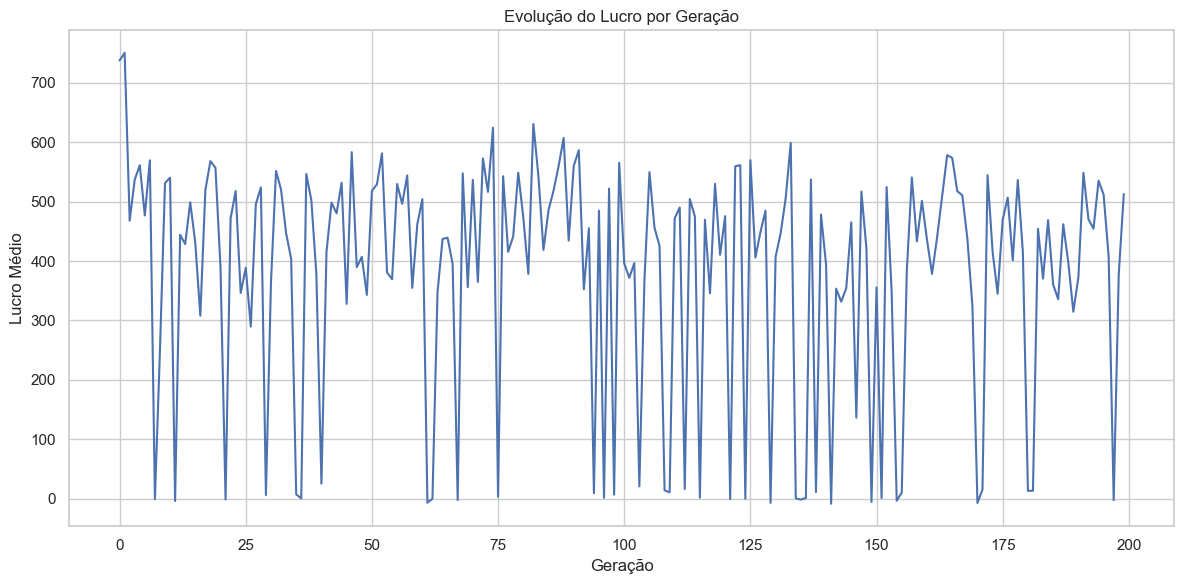

In [12]:
# 1. Evolução do lucro ao longo das gerações (linha)
profit_by_generation = df.groupby("generation")["profit_loss"].mean().reset_index()
plt.figure()
sns.lineplot(data=profit_by_generation, x="generation", y="profit_loss")
plt.title("Evolução do Lucro por Geração")
plt.xlabel("Geração")
plt.ylabel("Lucro Médio")
plt.tight_layout()
plt.savefig("evidencias-artigo/lucro_por_geracao.png")
plt.show()
plt.close()

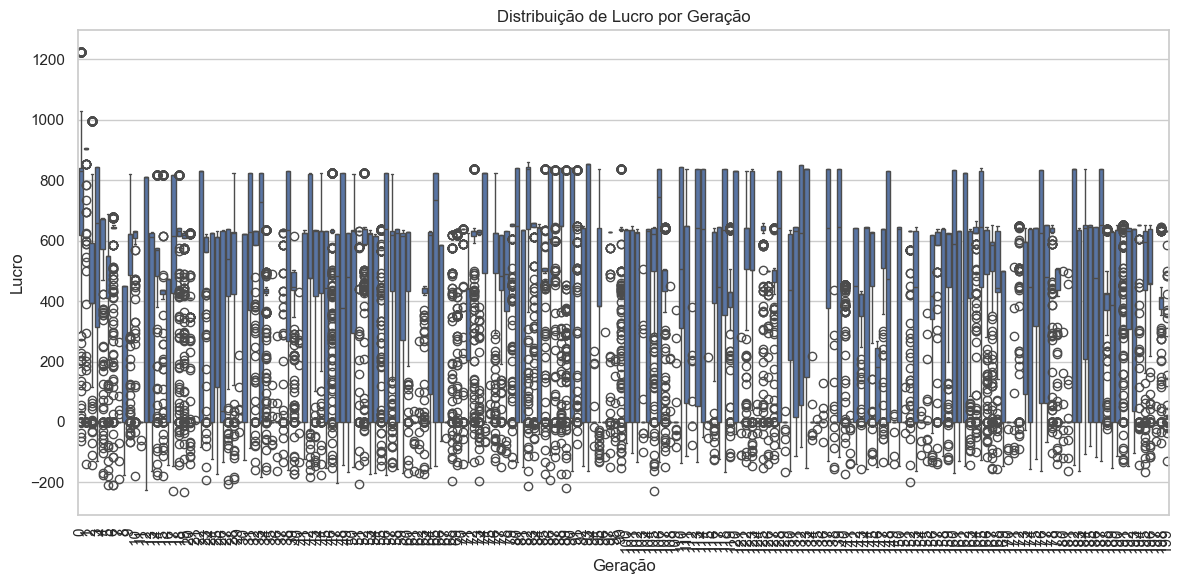

In [13]:
# 2. Distribuição de lucro por geração (boxplot)
plt.figure()
sns.boxplot(data=df, x="generation", y="profit_loss")
plt.title("Distribuição de Lucro por Geração")
plt.xlabel("Geração")
plt.ylabel("Lucro")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("evidencias-artigo/boxplot_lucro_geracao.png")
plt.show()
plt.close()

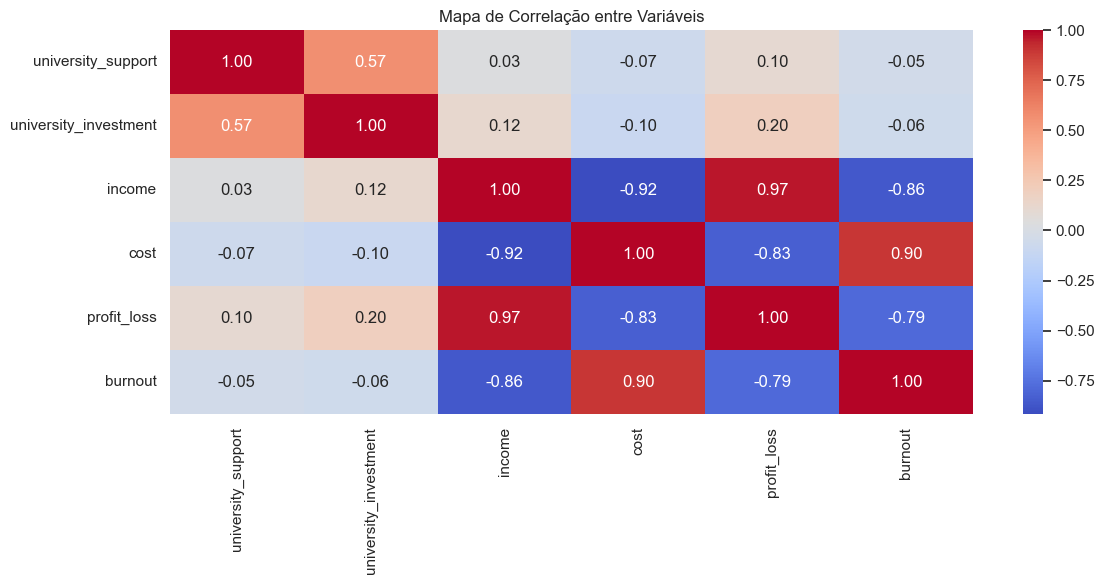

In [14]:
# 3. Heatmap de correlação
plt.figure()
correlation = df[["university_support", "university_investment", "income", "cost", "profit_loss","burnout"]].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação entre Variáveis")
plt.tight_layout()
plt.savefig("evidencias-artigo/heatmap_correlacao.png")
plt.show()
plt.close()

In [37]:
# Calcula a correlação entre as colunas selecionadas
correlation = df[["university_support", "university_investment", "income", "cost", "profit_loss", "burnout"]].corr()

# Imprime a tabela com duas casas decimais
print(correlation.round(2).to_string())

                       university_support  university_investment  income  cost  profit_loss  burnout
university_support                   1.00                   0.57    0.03 -0.07         0.10    -0.05
university_investment                0.57                   1.00    0.12 -0.10         0.20    -0.06
income                               0.03                   0.12    1.00 -0.92         0.97    -0.86
cost                                -0.07                  -0.10   -0.92  1.00        -0.83     0.90
profit_loss                          0.10                   0.20    0.97 -0.83         1.00    -0.79
burnout                             -0.05                  -0.06   -0.86  0.90        -0.79     1.00


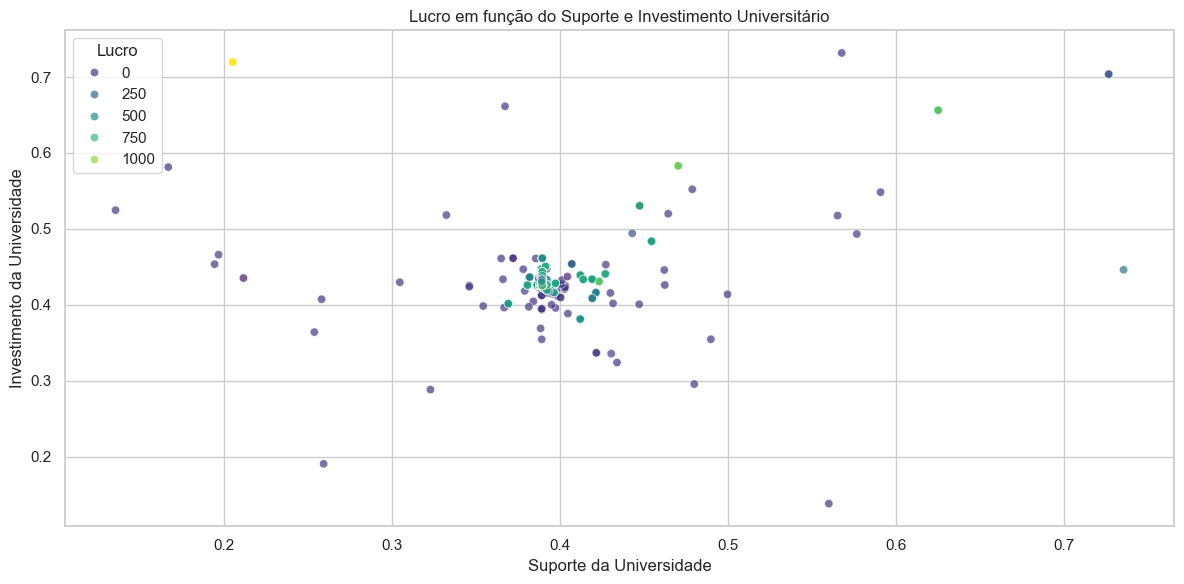

In [38]:
# 4. Scatter plot 2D: suporte vs investimento, cor = lucro
plt.figure()
sns.scatterplot(data=df.sample(10000), x="university_support", y="university_investment",
                hue="profit_loss", palette="viridis", alpha=0.7)
plt.title("Lucro em função do Suporte e Investimento Universitário")
plt.xlabel("Suporte da Universidade")
plt.ylabel("Investimento da Universidade")
plt.legend(title="Lucro", loc="best")
plt.tight_layout()
plt.savefig("evidencias-artigo/scatter_suporte_investimento_lucro.png")
plt.show()
plt.close()

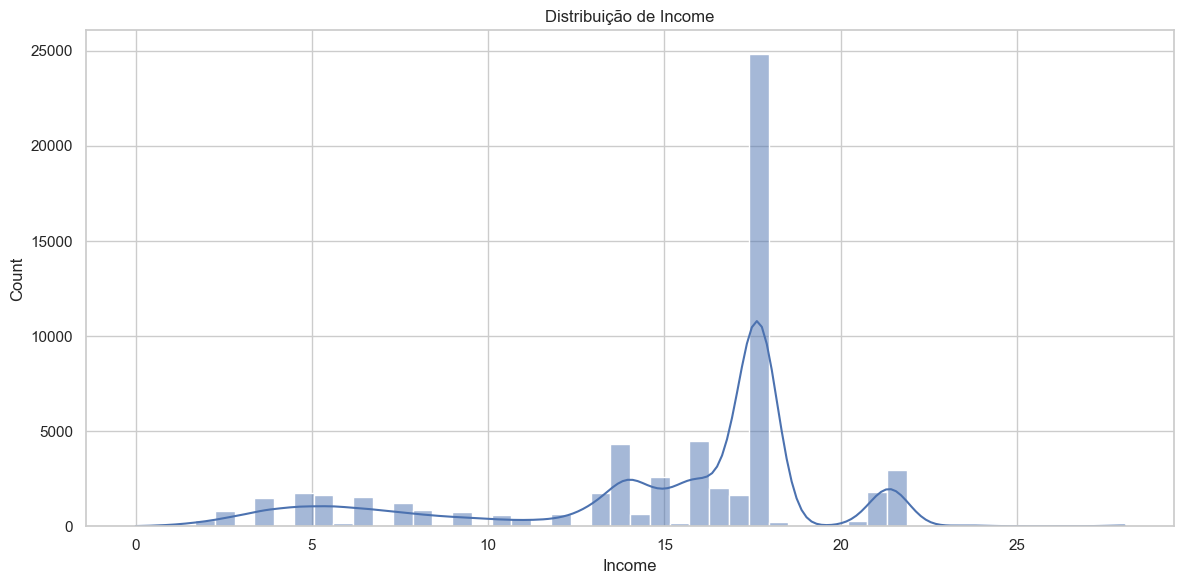

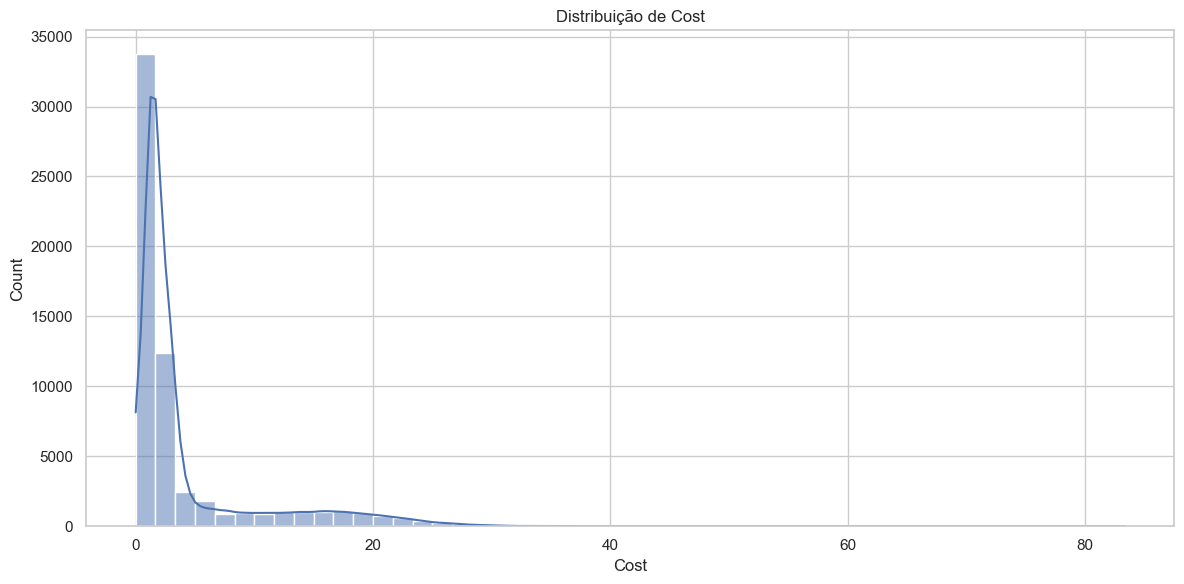

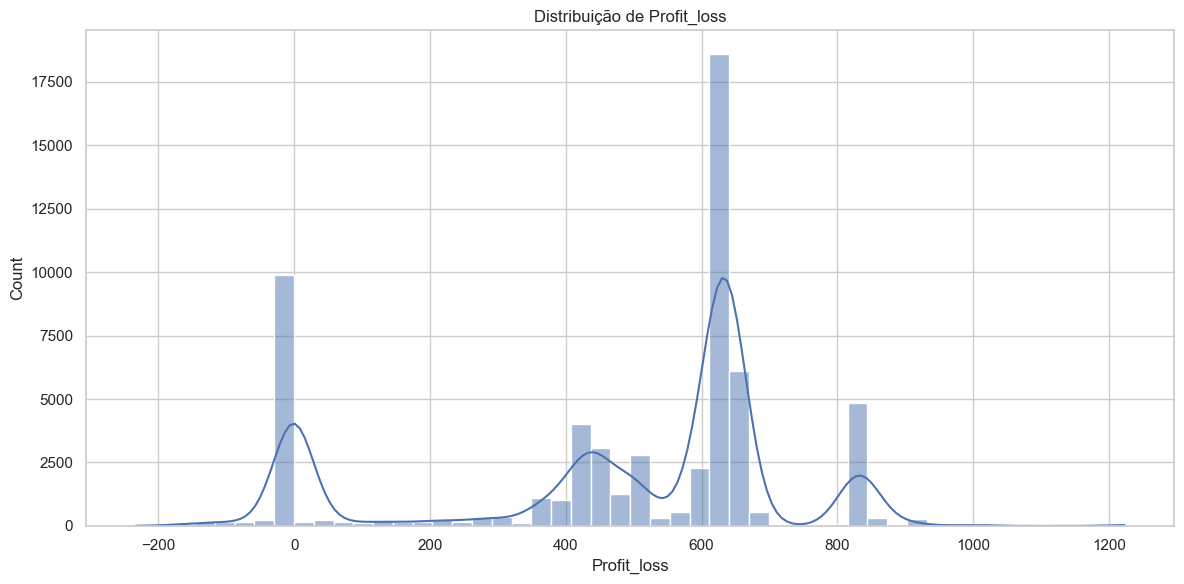

In [39]:
# 5. Histogramas: income, cost, profit_loss
for col in ["income", "cost", "profit_loss"]:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f"Distribuição de {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.tight_layout()
    plt.savefig(f"evidencias-artigo/histograma_{col}.png")
    plt.show()
    plt.close()

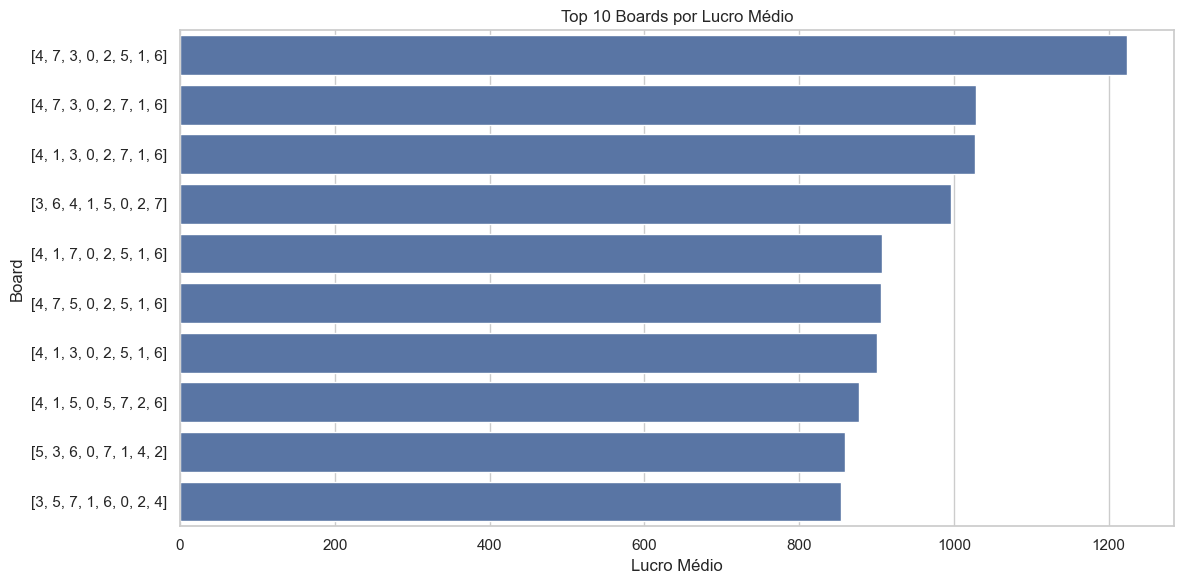

In [40]:
# 6. Bar chart dos top 10 boards por lucro médio
df["board_str"] = df["board"].apply(lambda x: str(x))

board_profit = df.groupby("board_str")["profit_loss"].mean().sort_values(ascending=False).head(10)
plt.figure()
sns.barplot(x=board_profit.values, y=board_profit.index)
plt.title("Top 10 Boards por Lucro Médio")
plt.xlabel("Lucro Médio")
plt.ylabel("Board")
plt.tight_layout()
plt.savefig("evidencias-artigo/top10_boards_lucro.png")
plt.show()
plt.close()

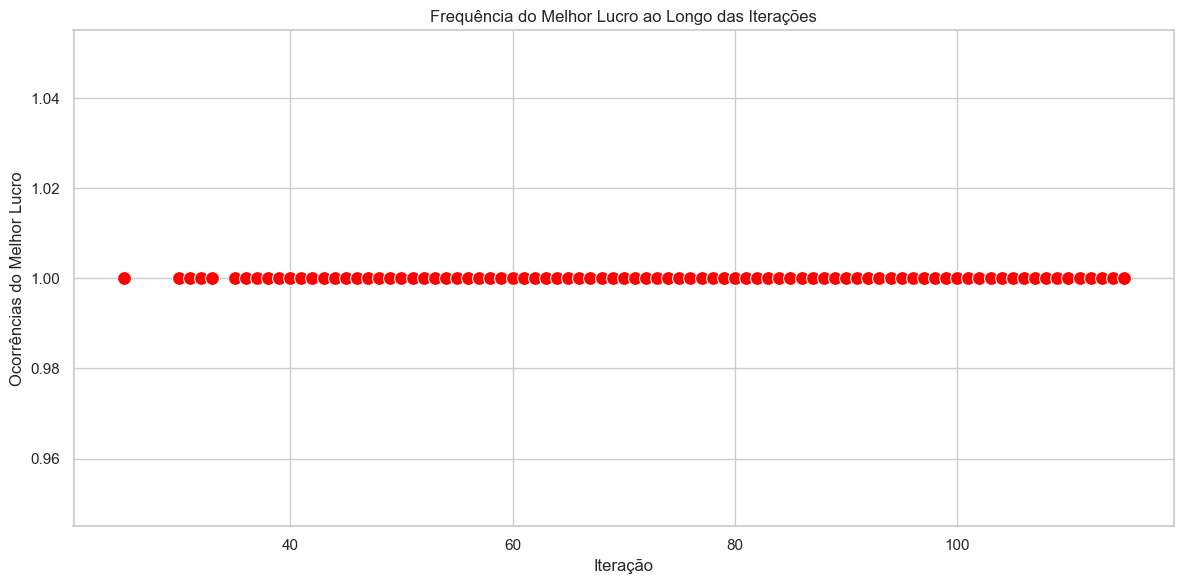

In [41]:
# Encontrar o maior lucro
max_profit = df["profit_loss"].max()

# Criar uma coluna para marcar onde o maior lucro foi atingido
df["is_best_profit"] = df["profit_loss"] == max_profit

# Contar quantas vezes o melhor lucro foi atingido em cada iteração
best_profit_duration = df.groupby("iteration")["is_best_profit"].sum().reset_index()

# Filtrar apenas iterações em que o melhor lucro foi atingido
best_profit_duration = best_profit_duration[best_profit_duration["is_best_profit"] > 0]

# Plotar gráfico
plt.figure(figsize=(12, 6))
sns.scatterplot(data=best_profit_duration, x="iteration", y="is_best_profit", s=100, color="red")
plt.title("Frequência do Melhor Lucro ao Longo das Iterações")
plt.xlabel("Iteração")
plt.ylabel("Ocorrências do Melhor Lucro")
plt.tight_layout()
plt.savefig("evidencias-artigo/melhor_lucro_por_iteracao.png")
plt.show()

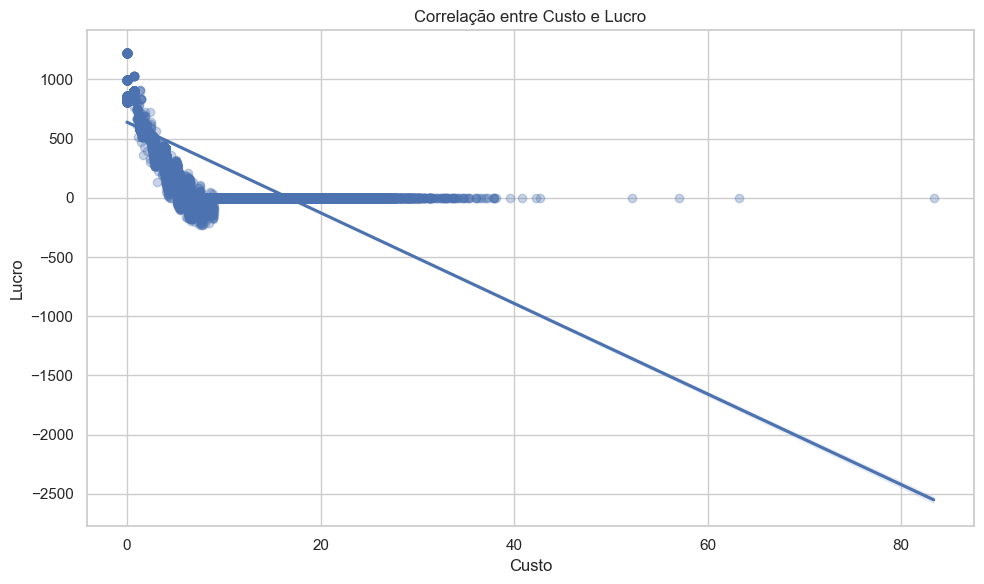

In [42]:
sns.set(style="whitegrid")

# Gráfico de dispersão com linha de regressão
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x="cost", y="profit_loss", scatter_kws={"alpha":0.3})
plt.title("Correlação entre Custo e Lucro")
plt.xlabel("Custo")
plt.ylabel("Lucro")
plt.tight_layout()
plt.savefig("evidencias-artigo/correlacao_custo_lucro.png")
plt.show()

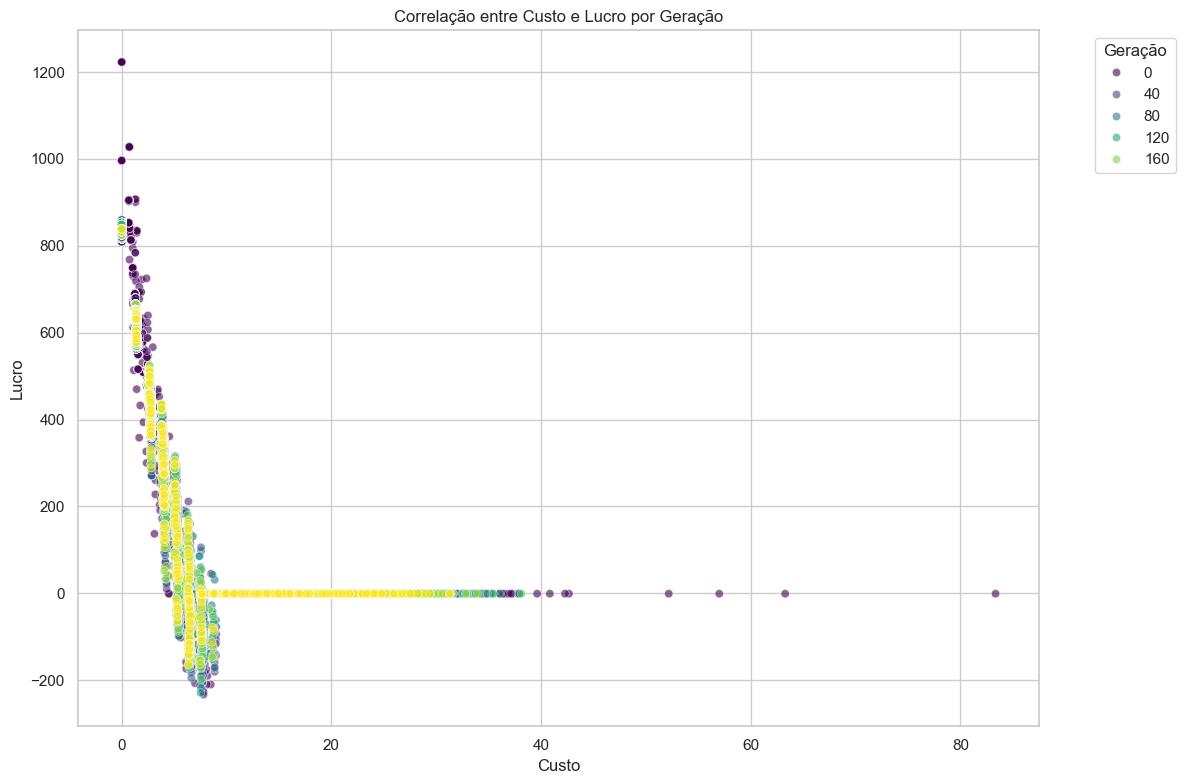

In [43]:
# Configuração do estilo
sns.set(style="whitegrid")

# Gráfico de dispersão colorido por geração
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="cost", y="profit_loss", hue="generation", palette="viridis", alpha=0.6)

plt.title("Correlação entre Custo e Lucro por Geração")
plt.xlabel("Custo")
plt.ylabel("Lucro")
plt.legend(title="Geração", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("evidencias-artigo/correlacao_custo_lucro_por_geracao.png")
plt.show()

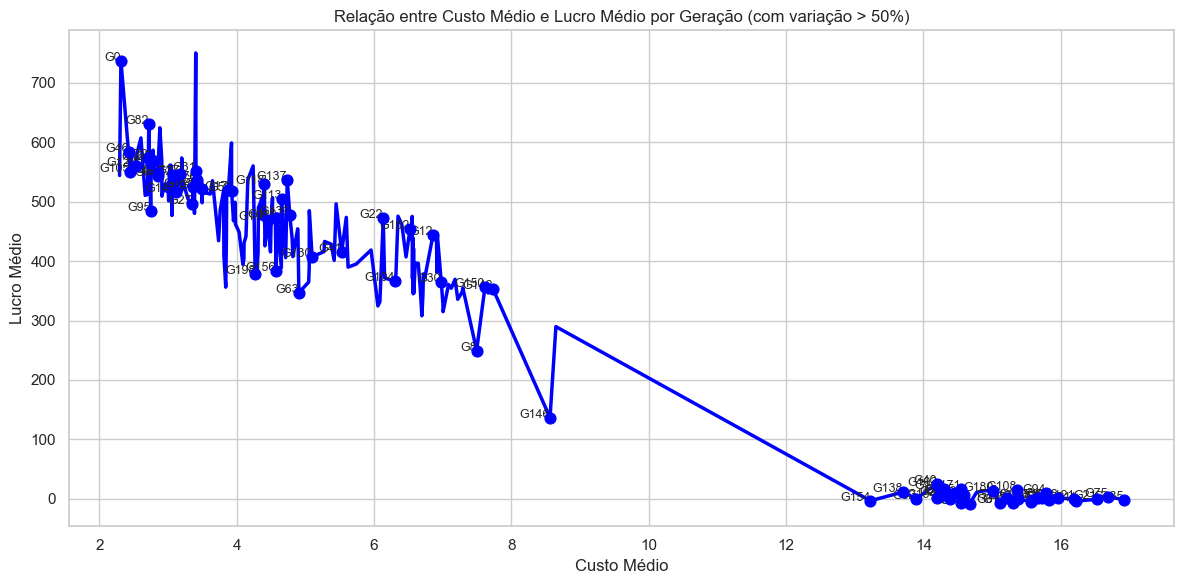

In [62]:
# Agrupar por geração e calcular médias
df_grouped = df.groupby("generation")[["cost", "profit_loss"]].mean().reset_index()

# Calcular variação percentual absoluta do lucro entre gerações
df_grouped["profit_var_pct"] = df_grouped["profit_loss"].pct_change().abs()

# Aplicar filtro: manter somente pontos com variação > 50% ou o primeiro ponto (G0)
df_grouped["show_point"] = (df_grouped["profit_var_pct"] > 0.50) | (df_grouped["generation"] == df_grouped["generation"].min())

# Separar dados filtrados para exibir no gráfico
df_filtered = df_grouped[df_grouped["show_point"]]

# Plotar linha principal
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x="cost", y="profit_loss", color="blue", linewidth=2.5)

# Adicionar somente os pontos filtrados
plt.scatter(df_filtered["cost"], df_filtered["profit_loss"], color="blue", s=60, zorder=5)

# Adicionar rótulos apenas para os pontos filtrados
for _, row in df_filtered.iterrows():
    plt.text(row["cost"], row["profit_loss"], f'G{int(row["generation"])}', fontsize=9, ha='right')

plt.title("Relação entre Custo Médio e Lucro Médio por Geração (com variação > 50%)")
plt.xlabel("Custo Médio")
plt.ylabel("Lucro Médio")
plt.grid(True)
plt.tight_layout()
plt.savefig("evidencias-artigo/media_custo_lucro_filtrado_por_variacao.png")
plt.show()

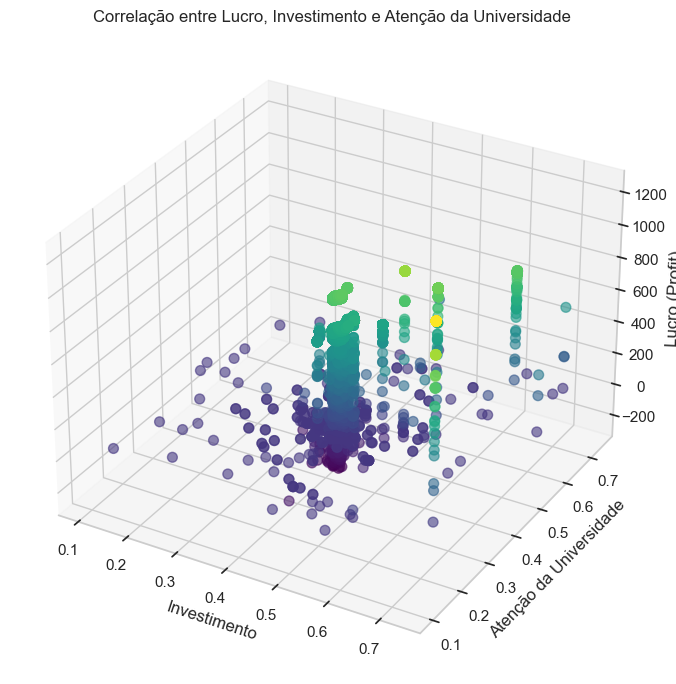

In [45]:
# Verificar se as colunas necessárias existem
required_cols = {"university_investment", "university_support", "profit_loss"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"O DataFrame não contém as colunas: {required_cols - set(df.columns)}")

# Criar gráfico 3D de dispersão
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df["university_investment"],
    df["university_support"],
    df["profit_loss"],
    c=df["profit_loss"],
    cmap='viridis',
    s=50,
    alpha=0.6
)

ax.set_xlabel("Investimento")
ax.set_ylabel("Atenção da Universidade")
ax.set_zlabel("Lucro (Profit)")
ax.set_title("Correlação entre Lucro, Investimento e Atenção da Universidade")
plt.tight_layout()
plt.savefig("evidencias-artigo/correlacao_lucro_investimento_atencao.png")
plt.show()

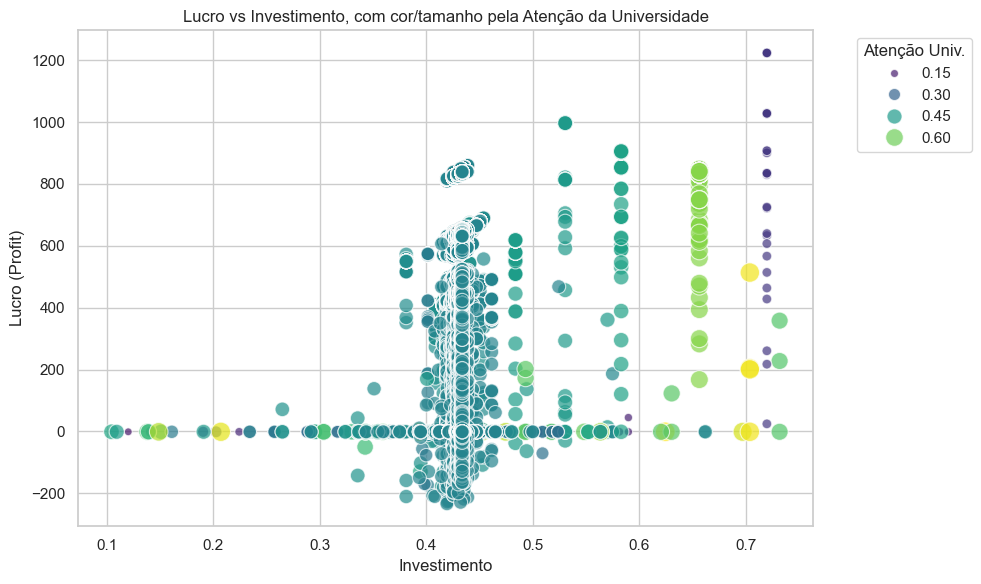

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="university_investment",
    y="profit_loss",
    hue="university_support",
    palette="viridis",
    size="university_support",
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Lucro vs Investimento, com cor/tamanho pela Atenção da Universidade")
plt.xlabel("Investimento")
plt.ylabel("Lucro (Profit)")
plt.legend(title="Atenção Univ.", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("evidencias-artigo/lucro_vs_investimento_com_atencao.png")
plt.show()

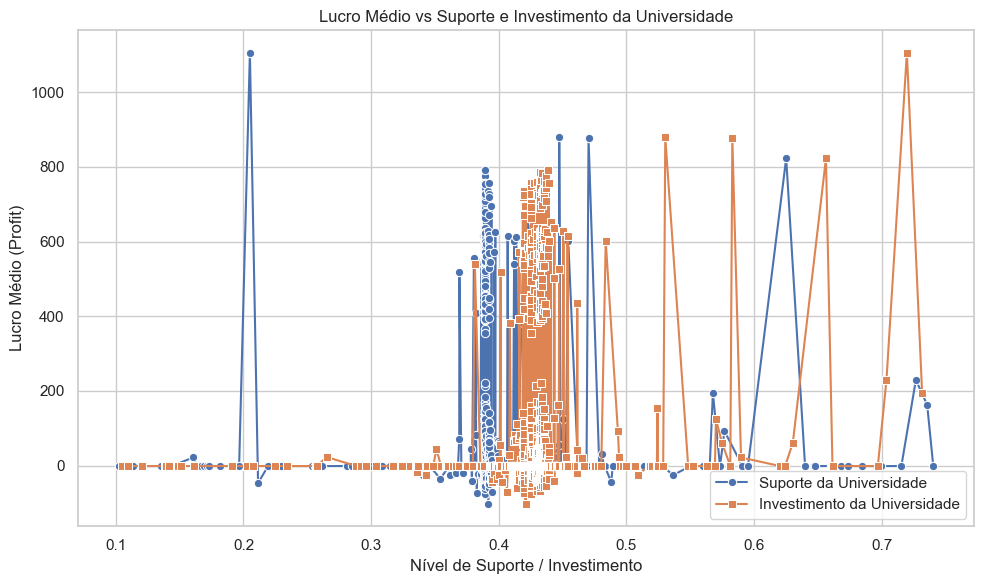

In [47]:
# Verificar colunas necessárias
required_cols = {"profit_loss", "university_support", "university_investment"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"Faltando colunas: {required_cols - set(df.columns)}")

# Agrupar por suporte da universidade
support_mean = df.groupby("university_support")["profit_loss"].mean().reset_index()
support_mean = support_mean.sort_values("university_support")

# Agrupar por investimento da universidade
investment_mean = df.groupby("university_investment")["profit_loss"].mean().reset_index()
investment_mean = investment_mean.sort_values("university_investment")

# Plotar gráfico de linha
plt.figure(figsize=(10, 6))

sns.lineplot(data=support_mean, x="university_support", y="profit_loss", marker="o", label="Suporte da Universidade")
sns.lineplot(data=investment_mean, x="university_investment", y="profit_loss", marker="s", label="Investimento da Universidade")

plt.title("Lucro Médio vs Suporte e Investimento da Universidade")
plt.xlabel("Nível de Suporte / Investimento")
plt.ylabel("Lucro Médio (Profit)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("evidencias-artigo/linha_lucro_suporte_investimento.png")
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/1301341052.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support_group = df.groupby("support_bin")["profit_loss"].mean().reset_index()
/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/1301341052.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  investment_group = df.groupby("investment_bin")["profit_loss"].mean().reset_index()


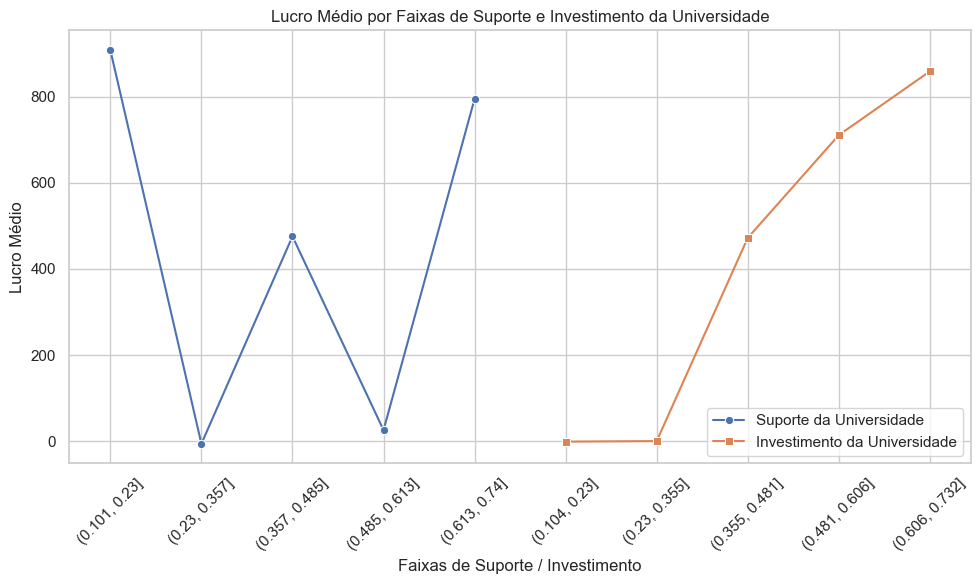

In [48]:
# Verificar colunas
required_cols = {"profit_loss", "university_support", "university_investment"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"Faltando colunas: {required_cols - set(df.columns)}")

# Agrupar em faixas (bins) para reduzir ruído
df["support_bin"] = pd.cut(df["university_support"], bins=5)
df["investment_bin"] = pd.cut(df["university_investment"], bins=5)

# Calcular lucro médio por faixa de suporte
support_group = df.groupby("support_bin")["profit_loss"].mean().reset_index()
support_group["label"] = support_group["support_bin"].astype(str)

# Calcular lucro médio por faixa de investimento
investment_group = df.groupby("investment_bin")["profit_loss"].mean().reset_index()
investment_group["label"] = investment_group["investment_bin"].astype(str)

# Plotar gráfico
plt.figure(figsize=(10, 6))

sns.lineplot(data=support_group, x="label", y="profit_loss", marker="o", label="Suporte da Universidade")
sns.lineplot(data=investment_group, x="label", y="profit_loss", marker="s", label="Investimento da Universidade")

plt.xticks(rotation=45)
plt.title("Lucro Médio por Faixas de Suporte e Investimento da Universidade")
plt.xlabel("Faixas de Suporte / Investimento")
plt.ylabel("Lucro Médio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("evidencias-artigo/lucro_medio_faixas_suporte_investimento.png")
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/2176215072.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("support_bin")["profit_loss"].mean().reset_index()


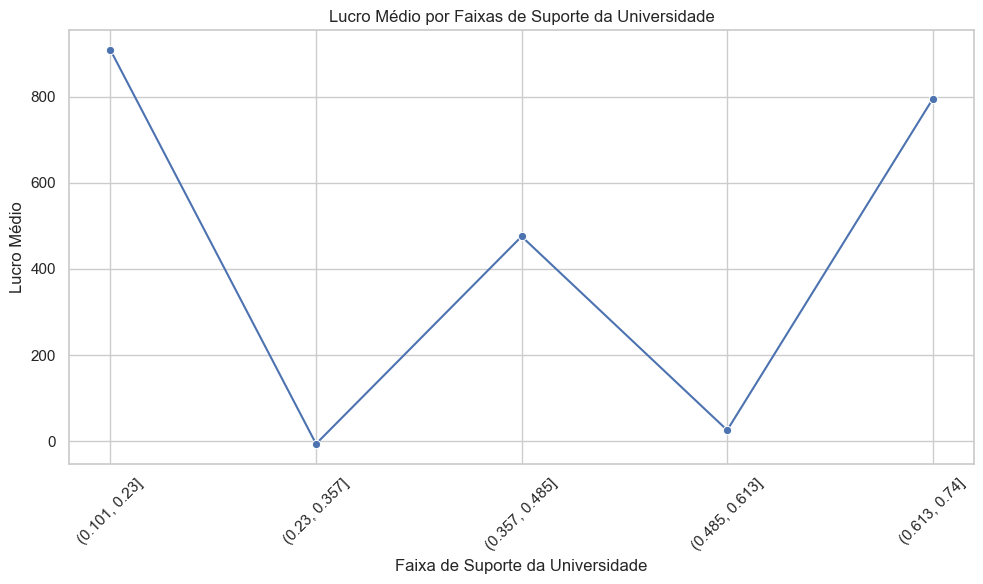

In [49]:
# Verificar se as colunas existem
if "university_support" not in df.columns or "profit_loss" not in df.columns:
    raise ValueError("Colunas 'university_support' e/ou 'profit_loss' não encontradas.")

# Agrupar o suporte em faixas (bins)
df["support_bin"] = pd.cut(df["university_support"], bins=5)

# Calcular lucro médio por faixa
grouped = df.groupby("support_bin")["profit_loss"].mean().reset_index()
grouped["label"] = grouped["support_bin"].astype(str)

# Plotar gráfico de linha com os pontos médios
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x="label", y="profit_loss", marker="o")
plt.title("Lucro Médio por Faixas de Suporte da Universidade")
plt.xlabel("Faixa de Suporte da Universidade")
plt.ylabel("Lucro Médio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("evidencias-artigo/lucro_medio_por_suporte.png")
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/2666584266.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_invest = df.groupby("investment_bin")["profit_loss"].mean().reset_index()


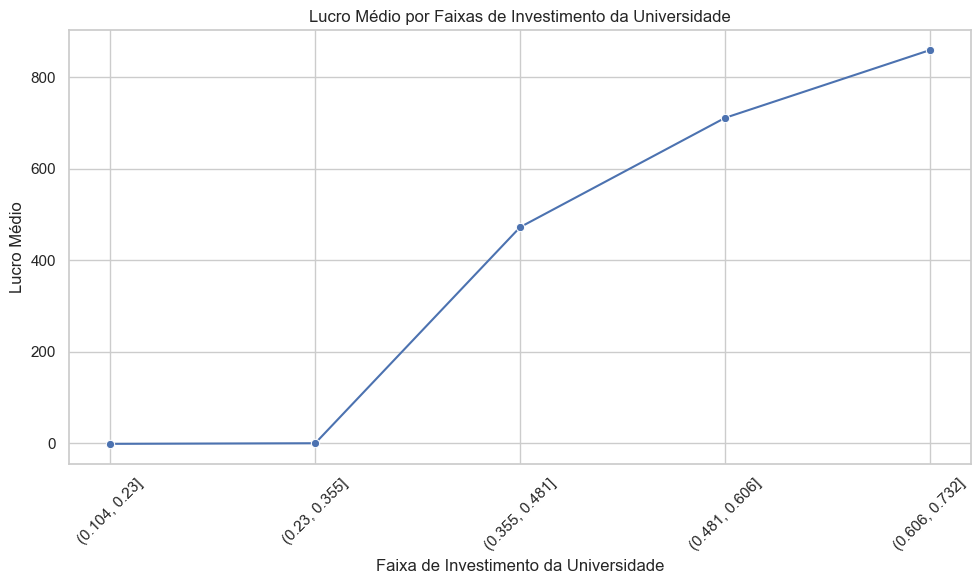

In [50]:
# Verificar se as colunas existem
if "university_investment" not in df.columns or "profit_loss" not in df.columns:
    raise ValueError("Colunas 'university_investment' e/ou 'profit_loss' não encontradas.")

# Agrupar o investimento em faixas (bins)
df["investment_bin"] = pd.cut(df["university_investment"], bins=5)

# Calcular lucro médio por faixa de investimento
grouped_invest = df.groupby("investment_bin")["profit_loss"].mean().reset_index()
grouped_invest["label"] = grouped_invest["investment_bin"].astype(str)

# Plotar gráfico de linha com os pontos médios
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_invest, x="label", y="profit_loss", marker="o")
plt.title("Lucro Médio por Faixas de Investimento da Universidade")
plt.xlabel("Faixa de Investimento da Universidade")
plt.ylabel("Lucro Médio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("evidencias-artigo/lucro_medio_por_investimento.png")
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/3577938425.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["support_bin", "investment_bin"]).agg({


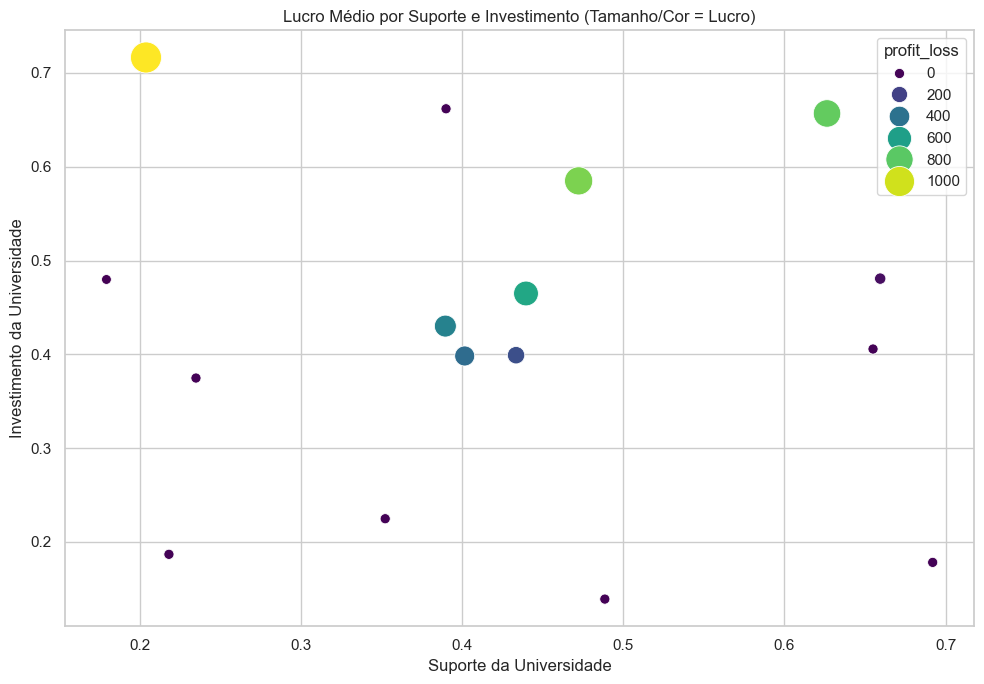

In [51]:
df["support_bin"] = pd.cut(df["university_support"], bins=4)
df["investment_bin"] = pd.cut(df["university_investment"], bins=4)

grouped = df.groupby(["support_bin", "investment_bin"]).agg({
    "university_support": "mean",
    "university_investment": "mean",
    "profit_loss": "mean"
}).reset_index()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=grouped,
    x="university_support",
    y="university_investment",
    size="profit_loss",
    hue="profit_loss",
    sizes=(50, 500),
    palette="viridis",
    legend="brief"
)
plt.xlabel("Suporte da Universidade")
plt.ylabel("Investimento da Universidade")
plt.title("Lucro Médio por Suporte e Investimento (Tamanho/Cor = Lucro)")
plt.grid(True)
plt.tight_layout()
plt.savefig("evidencias-artigo/correlacao_lucro_bubble_chart.png")
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/1027238781.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["support_bin", "investment_bin"]).agg({


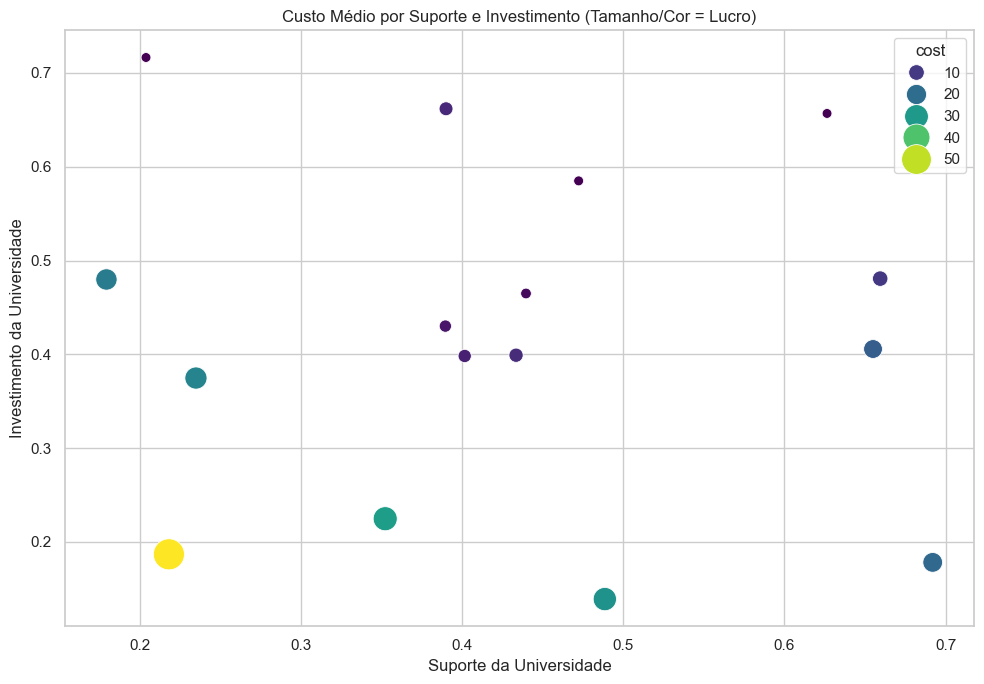

In [52]:
df["support_bin"] = pd.cut(df["university_support"], bins=4)
df["investment_bin"] = pd.cut(df["university_investment"], bins=4)

grouped = df.groupby(["support_bin", "investment_bin"]).agg({
    "university_support": "mean",
    "university_investment": "mean",
    "cost": "mean"
}).reset_index()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=grouped,
    x="university_support",
    y="university_investment",
    size="cost",
    hue="cost",
    sizes=(50, 500),
    palette="viridis",
    legend="brief"
)
plt.xlabel("Suporte da Universidade")
plt.ylabel("Investimento da Universidade")
plt.title("Custo Médio por Suporte e Investimento (Tamanho/Cor = Lucro)")
plt.grid(True)
plt.tight_layout()
plt.savefig("evidencias-artigo/correlacao_custo_bubble_chart.png")
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/714547300.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["support_bin", "investment_bin"]).agg({


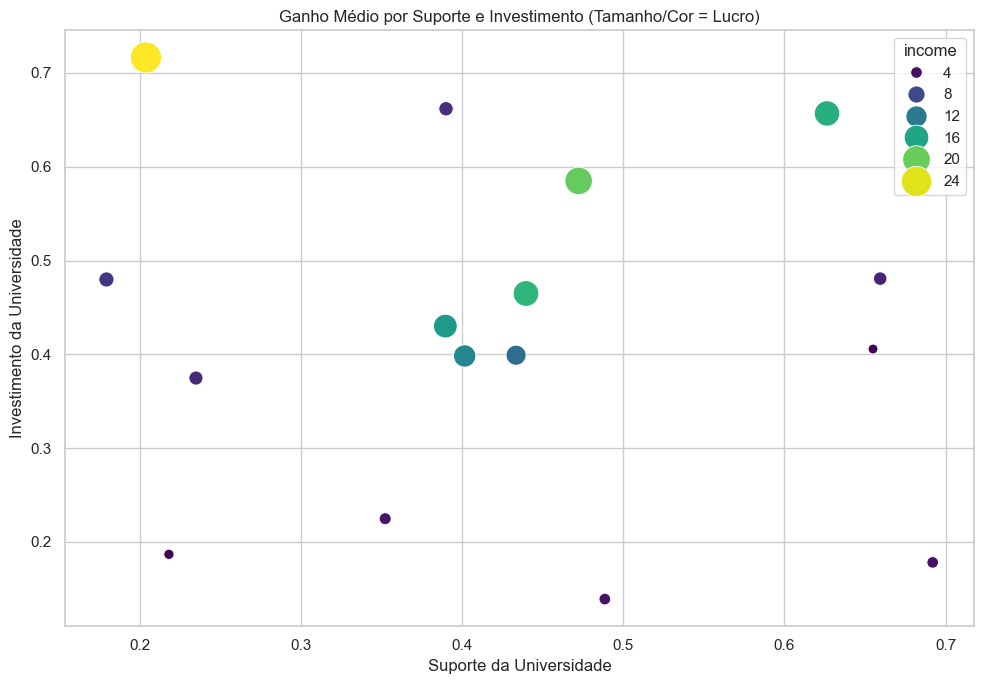

In [53]:
df["support_bin"] = pd.cut(df["university_support"], bins=4)
df["investment_bin"] = pd.cut(df["university_investment"], bins=4)

grouped = df.groupby(["support_bin", "investment_bin"]).agg({
    "university_support": "mean",
    "university_investment": "mean",
    "income": "mean"
}).reset_index()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=grouped,
    x="university_support",
    y="university_investment",
    size="income",
    hue="income",
    sizes=(50, 500),
    palette="viridis",
    legend="brief"
)
plt.xlabel("Suporte da Universidade")
plt.ylabel("Investimento da Universidade")
plt.title("Ganho Médio por Suporte e Investimento (Tamanho/Cor = Lucro)")
plt.grid(True)
plt.tight_layout()
plt.savefig("evidencias-artigo/correlacao_ganho_bubble_chart.png")
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/968669219.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  burnout_by_cost = df.groupby("cost_bin")["burnout"].mean().reset_index()


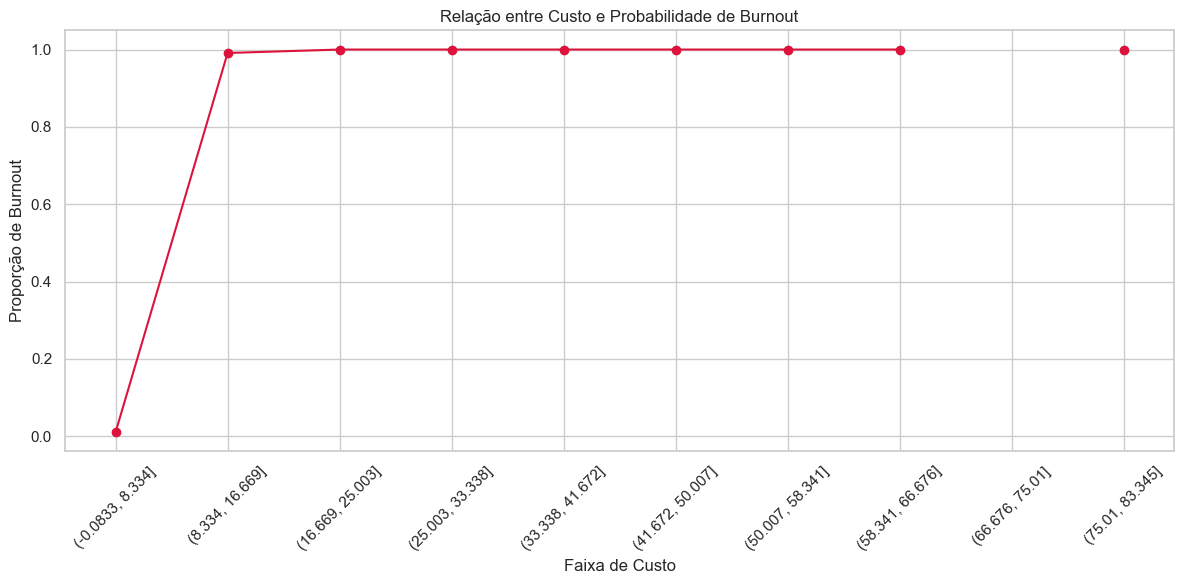

In [54]:
# Supondo que seu DataFrame se chama df e já contém a coluna "burnout"
# Cria faixas (bins) de custo
df["cost_bin"] = pd.cut(df["cost"], bins=10)

# Calcula a proporção de burnout em cada faixa de custo
burnout_by_cost = df.groupby("cost_bin")["burnout"].mean().reset_index()

# Converte faixas para string para facilitar visualização no eixo x
burnout_by_cost["cost_bin"] = burnout_by_cost["cost_bin"].astype(str)

# Plota o gráfico
plt.figure(figsize=(12, 6))
plt.plot(burnout_by_cost["cost_bin"], burnout_by_cost["burnout"], marker="o", color="crimson")
plt.xticks(rotation=45)
plt.xlabel("Faixa de Custo")
plt.ylabel("Proporção de Burnout")
plt.title("Relação entre Custo e Probabilidade de Burnout")
plt.savefig("evidencias-artigo/relacao-custo-probabilidade-burnout.png")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/546127428.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  burnout_by_income = df.groupby("income_bin")["burnout"].mean().reset_index()


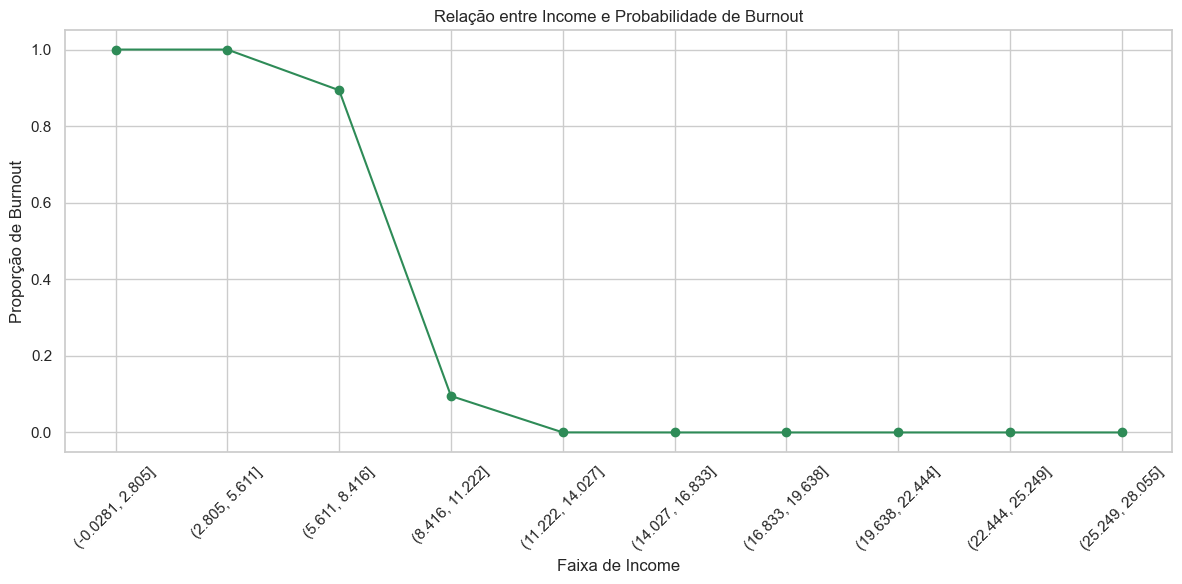

In [55]:
# Cria faixas (bins) de income
df["income_bin"] = pd.cut(df["income"], bins=10)

# Calcula a proporção de burnout em cada faixa de income
burnout_by_income = df.groupby("income_bin")["burnout"].mean().reset_index()

# Converte faixas para string para o eixo x
burnout_by_income["income_bin"] = burnout_by_income["income_bin"].astype(str)

# Plota o gráfico
plt.figure(figsize=(12, 6))
plt.plot(burnout_by_income["income_bin"], burnout_by_income["burnout"], marker="o", color="seagreen")
plt.xticks(rotation=45)
plt.xlabel("Faixa de Income")
plt.ylabel("Proporção de Burnout")
plt.title("Relação entre Income e Probabilidade de Burnout")
plt.savefig("evidencias-artigo/relacao-ganho-probabilidade-burnout.png")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/1592913189.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  burnout_matrix = df.groupby(["support_bin", "investment_bin"])["burnout"].mean().unstack()


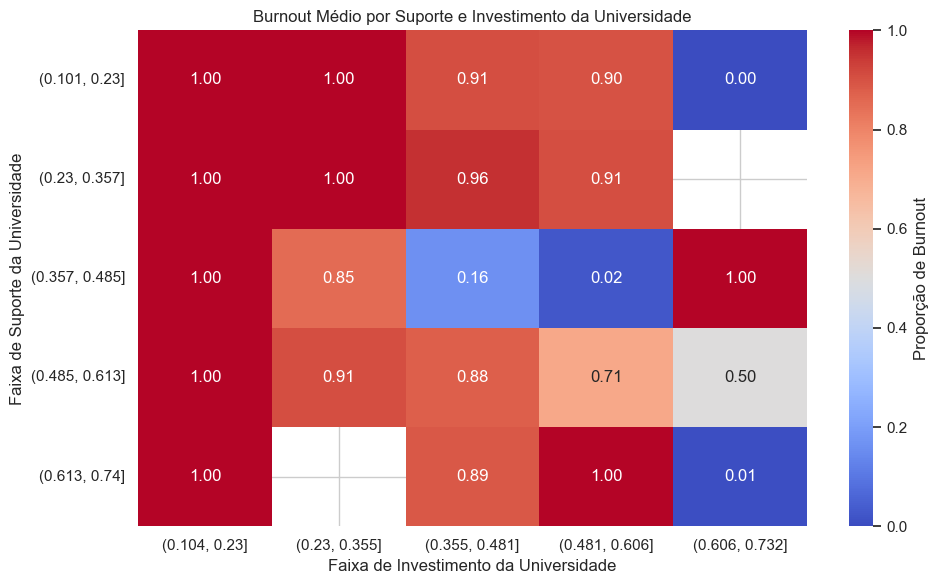

In [56]:
# Cria faixas para suporte e investimento
df["support_bin"] = pd.cut(df["university_support"], bins=5)
df["investment_bin"] = pd.cut(df["university_investment"], bins=5)

# Calcula a média de burnout por faixa
burnout_matrix = df.groupby(["support_bin", "investment_bin"])["burnout"].mean().unstack()

# Plota o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(burnout_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Proporção de Burnout'})
plt.xlabel("Faixa de Investimento da Universidade")
plt.ylabel("Faixa de Suporte da Universidade")
plt.title("Burnout Médio por Suporte e Investimento da Universidade")
plt.savefig("evidencias-artigo/burnout-medio-por-suporte-investimento-universidade-heatmap.png")
plt.tight_layout()
plt.show()


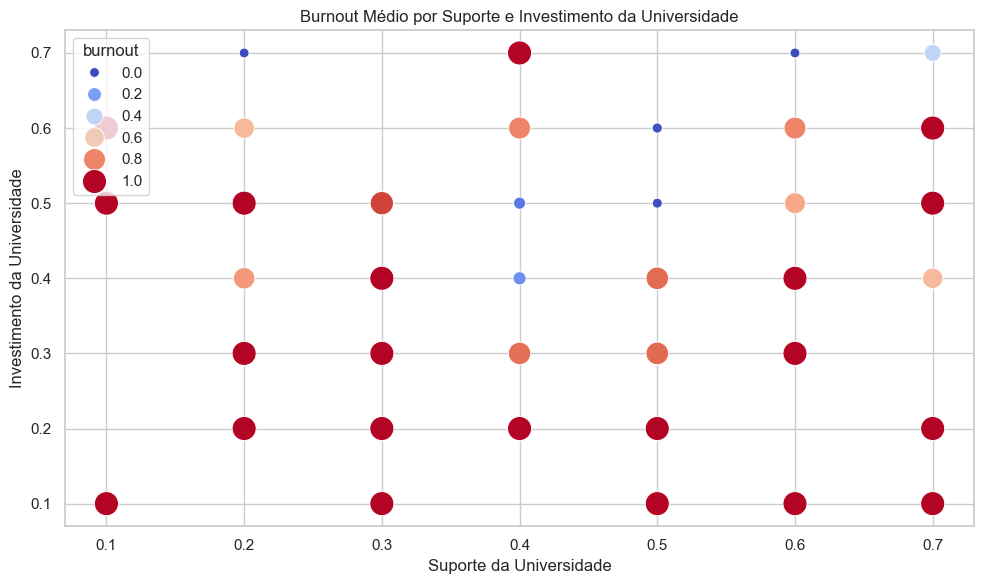

<Figure size 1200x600 with 0 Axes>

In [57]:
# Agrupa pelas combinações de suporte e investimento (arredondados para reduzir ruído)
grouped = df.copy()
grouped["university_support_r"] = grouped["university_support"].round(1)
grouped["university_investment_r"] = grouped["university_investment"].round(1)

agg = grouped.groupby(["university_support_r", "university_investment_r"]).agg({
    "burnout": "mean"
}).reset_index()

# Plota
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg,
    x="university_support_r",
    y="university_investment_r",
    size="burnout",
    hue="burnout",
    sizes=(50, 300),
    palette="coolwarm",
    legend="brief"
)
plt.xlabel("Suporte da Universidade")
plt.ylabel("Investimento da Universidade")
plt.title("Burnout Médio por Suporte e Investimento da Universidade")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("evidencias-artigo/burnout-medio-por-suporte-investimento-universidade-scatterplot.png")

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/3977729305.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_burnout = df.groupby("profit_bin")["burnout"].mean().reset_index()


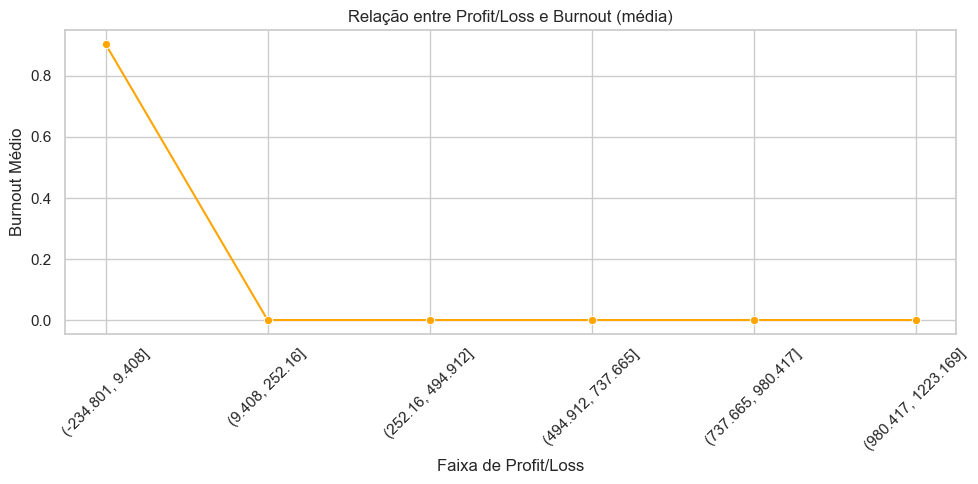

<Figure size 1200x600 with 0 Axes>

In [58]:
# Cria as faixas de profit_loss
df["profit_bin"] = pd.cut(df["profit_loss"], bins=6)

# Agrupa e calcula média de burnout
profit_burnout = df.groupby("profit_bin")["burnout"].mean().reset_index()

# Converte intervalo para string (etiqueta legível para o eixo x)
profit_burnout["profit_bin"] = profit_burnout["profit_bin"].astype(str)

# Plota gráfico de linha
plt.figure(figsize=(10, 5))
sns.lineplot(data=profit_burnout, x="profit_bin", y="burnout", marker="o", color="orange")
plt.title("Relação entre Profit/Loss e Burnout (média)")
plt.xlabel("Faixa de Profit/Loss")
plt.ylabel("Burnout Médio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("evidencias-artigo/relacao-entre-burnout-medio-profitloss.png")

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/2917410420.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_burnout = df.groupby("income_bin")["burnout"].mean().reset_index()


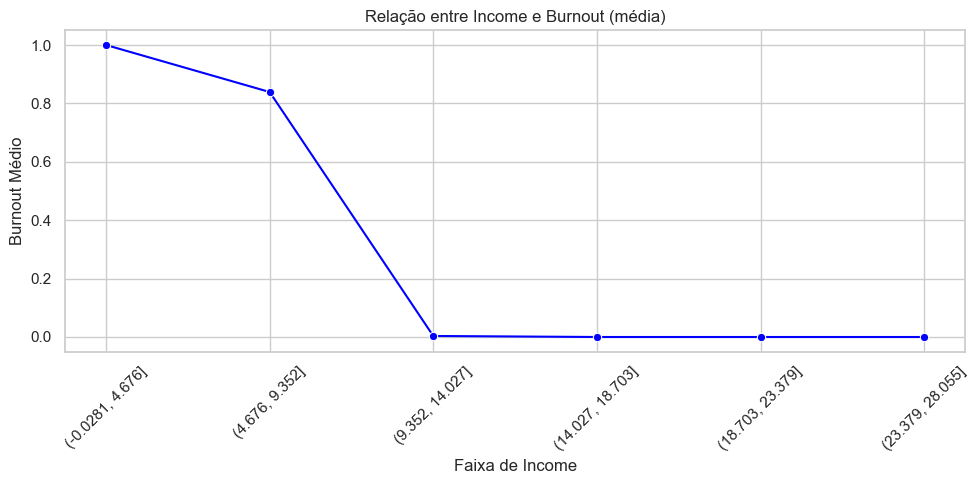

<Figure size 1200x600 with 0 Axes>

In [59]:
# Cria as faixas de income
df["income_bin"] = pd.cut(df["income"], bins=6)

# Agrupa e calcula média de burnout
income_burnout = df.groupby("income_bin")["burnout"].mean().reset_index()

# Converte intervalos em string
income_burnout["income_bin"] = income_burnout["income_bin"].astype(str)

# Plota
plt.figure(figsize=(10, 5))
sns.lineplot(data=income_burnout, x="income_bin", y="burnout", marker="o", color="blue")
plt.title("Relação entre Income e Burnout (média)")
plt.xlabel("Faixa de Income")
plt.ylabel("Burnout Médio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("evidencias-artigo/faixa-de-ganho-burnout-medio.png")

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/2080961916.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  burnout_ratio = df.groupby(['cost_bin', 'income_bin'])['burnout'].mean().reset_index()


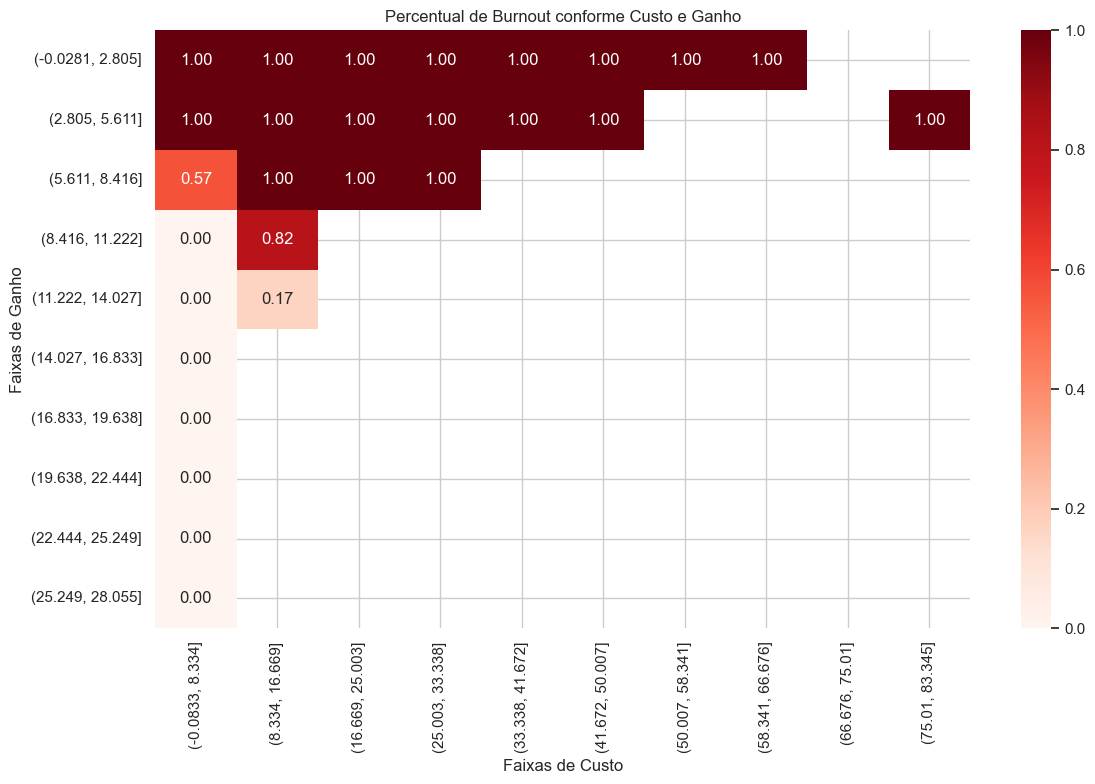

<Figure size 1200x600 with 0 Axes>

In [79]:
# Calcular proporção de burnout em faixas de custo e ganho
df['cost_bin'] = pd.cut(df['cost'], bins=10)
df['income_bin'] = pd.cut(df['income'], bins=10)

burnout_ratio = df.groupby(['cost_bin', 'income_bin'])['burnout'].mean().reset_index()
burnout_ratio_pivot = burnout_ratio.pivot(index='income_bin', columns='cost_bin', values='burnout')

# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(burnout_ratio_pivot, cmap="Reds", annot=True, fmt=".2f")
plt.title("Percentual de Burnout conforme Custo e Ganho")
plt.xlabel("Faixas de Custo")
plt.ylabel("Faixas de Ganho")
plt.tight_layout()
plt.show()
plt.savefig("evidencias-artigo/heatmap-burnout-conforme-ganho-e-custo.png")

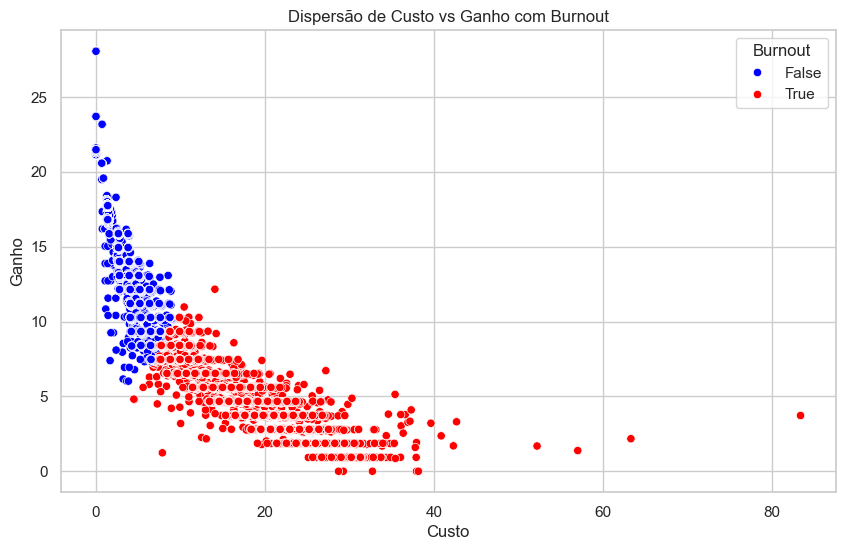

In [80]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='cost', y='income', hue='burnout', palette={True: 'red', False: 'blue'})
plt.title('Dispersão de Custo vs Ganho com Burnout')
plt.xlabel('Custo')
plt.ylabel('Ganho')
plt.legend(title='Burnout')
plt.savefig("evidencias-artigo/dispersao-custo-vs-ganho-com-burnout.png")
plt.show()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/3479260861.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  burnout_by_income = df.groupby('income_bin')['burnout'].mean().reset_index()


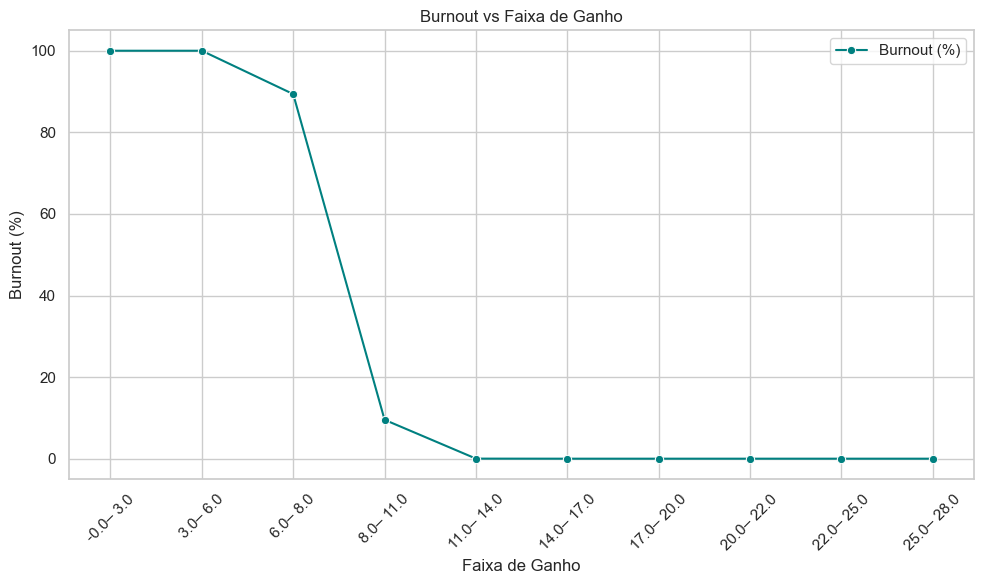

In [73]:
# Garantir que as colunas de bin estejam como string
df['income_bin'] = pd.cut(df['income'], bins=10, precision=0)
df['cost_bin'] = pd.cut(df['cost'], bins=10)

# Gráfico 1: Burnout vs Faixa de Ganho
burnout_by_income = df.groupby('income_bin')['burnout'].mean().reset_index()
burnout_by_income['burnout_percent'] = burnout_by_income['burnout'] * 100
burnout_by_income['income_bin'] = burnout_by_income['income_bin'].astype(str).str.replace(',', '–').str.replace('(', '').str.replace(']', '')

plt.figure(figsize=(10, 6))
sns.lineplot(data=burnout_by_income, x='income_bin', y='burnout_percent',
             marker='o', color='teal', label='Burnout (%)')
plt.title('Burnout vs Faixa de Ganho')
plt.xlabel('Faixa de Ganho')
plt.ylabel('Burnout (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('evidencias-artigo/burnout_vs_ganho.png', dpi=300)
plt.show()
plt.close()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/2954017729.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  burnout_by_cost = df.groupby('cost_bin')['burnout'].mean().reset_index()


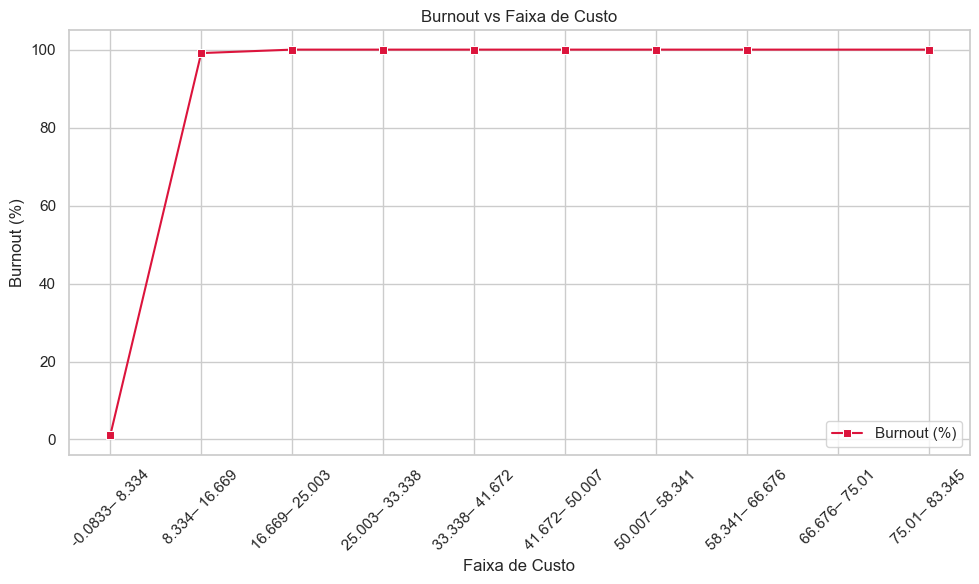

In [74]:
# Gráfico 2: Burnout vs Faixa de Custo
burnout_by_cost = df.groupby('cost_bin')['burnout'].mean().reset_index()
burnout_by_cost['burnout_percent'] = burnout_by_cost['burnout'] * 100
burnout_by_cost['cost_bin'] = burnout_by_cost['cost_bin'].astype(str).astype(str).str.replace(',', '–').str.replace('(', '').str.replace(']', '')

plt.figure(figsize=(10, 6))
sns.lineplot(data=burnout_by_cost, x='cost_bin', y='burnout_percent',
             marker='s', color='crimson', label='Burnout (%)')
plt.title('Burnout vs Faixa de Custo')
plt.xlabel('Faixa de Custo')
plt.ylabel('Burnout (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('evidencias-artigo/burnout_vs_custo.png', dpi=300)
plt.show()
plt.close()

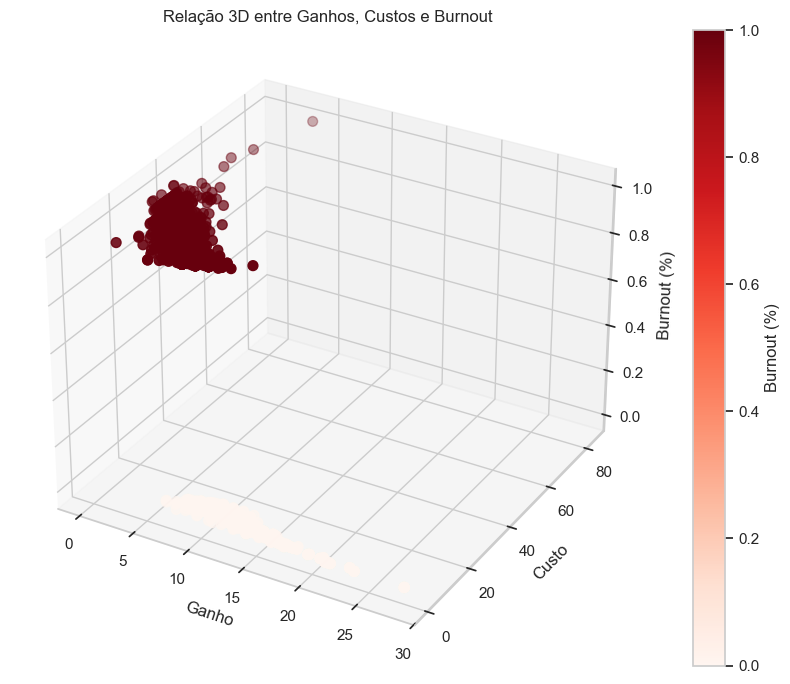

In [76]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df['income'], df['cost'], df['burnout'],
                c=df['burnout'], cmap='Reds', s=50)

ax.set_xlabel('Ganho')
ax.set_ylabel('Custo')
ax.set_zlabel('Burnout (%)')
plt.title('Relação 3D entre Ganhos, Custos e Burnout')
fig.colorbar(sc, label='Burnout (%)')
plt.tight_layout()
plt.savefig('evidencias-artigo/burnout_3d.png', dpi=300)
plt.show()
plt.close()

/var/folders/93/zlb0n5b1421gr2qxk916fl4m0000gn/T/ipykernel_68122/3385051399.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index='cost_bin', columns='income_bin', values='burnout', aggfunc='mean')


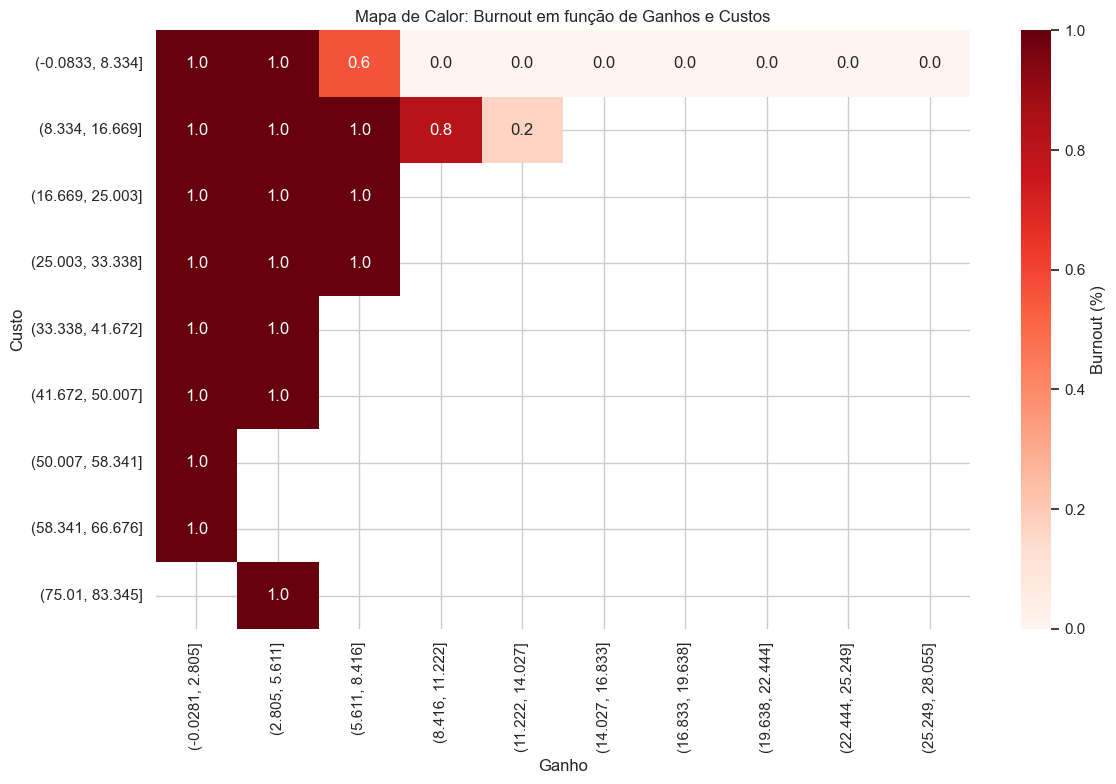

In [78]:
# Agrupar dados
df['income_bin'] = pd.cut(df['income'], bins=10)
df['cost_bin'] = pd.cut(df['cost'], bins=10)

pivot_table = df.pivot_table(index='cost_bin', columns='income_bin', values='burnout', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='Reds', annot=True, fmt=".1f", cbar_kws={'label': 'Burnout (%)'})
plt.xlabel('Ganho')
plt.ylabel('Custo')
plt.title('Mapa de Calor: Burnout em função de Ganhos e Custos')
plt.tight_layout()
plt.savefig('evidencias-artigo/burnout_heatmap.png', dpi=300)
plt.show()
plt.close()

In [87]:
# Criar coluna de agrupamento por blocos de 10 iterações
df['iteration_group'] = (df['iteration'] // 10) * 10  # 0-9, 10-19, etc.

# Agrupar por geração E por bloco de iteração
df_grouped = df.groupby(['generation', 'iteration_group']).mean(numeric_only=True).reset_index()

# Colunas a normalizar
cols_to_normalize = ['burnout', 'income', 'cost', 'profit_loss']

# Normalização (por todas as gerações juntas — global)
scaler = MinMaxScaler()
df_normalized = df_grouped.copy()
df_normalized[cols_to_normalize] = scaler.fit_transform(df_grouped[cols_to_normalize])

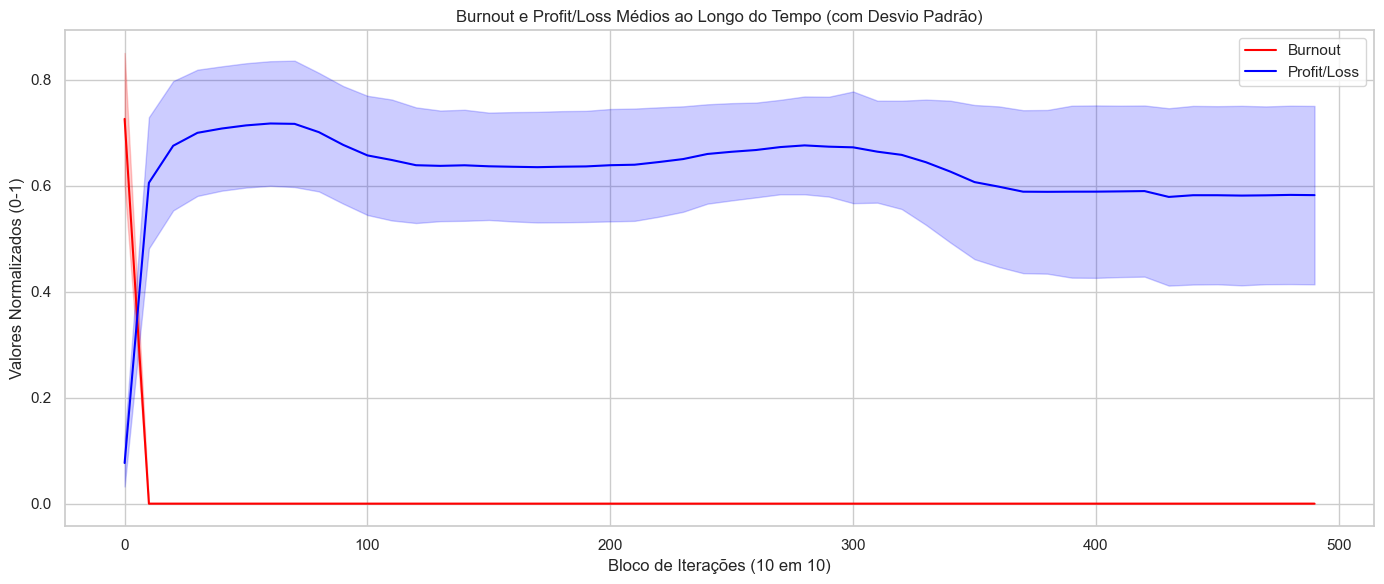

In [89]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_normalized, x='iteration_group', y='burnout', label='Burnout', color='red', errorbar='sd')
sns.lineplot(data=df_normalized, x='iteration_group', y='profit_loss', label='Profit/Loss', color='blue', errorbar='sd')
plt.title("Burnout e Profit/Loss Médios ao Longo do Tempo (com Desvio Padrão)")
plt.xlabel("Bloco de Iterações (10 em 10)")
plt.ylabel("Valores Normalizados (0-1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

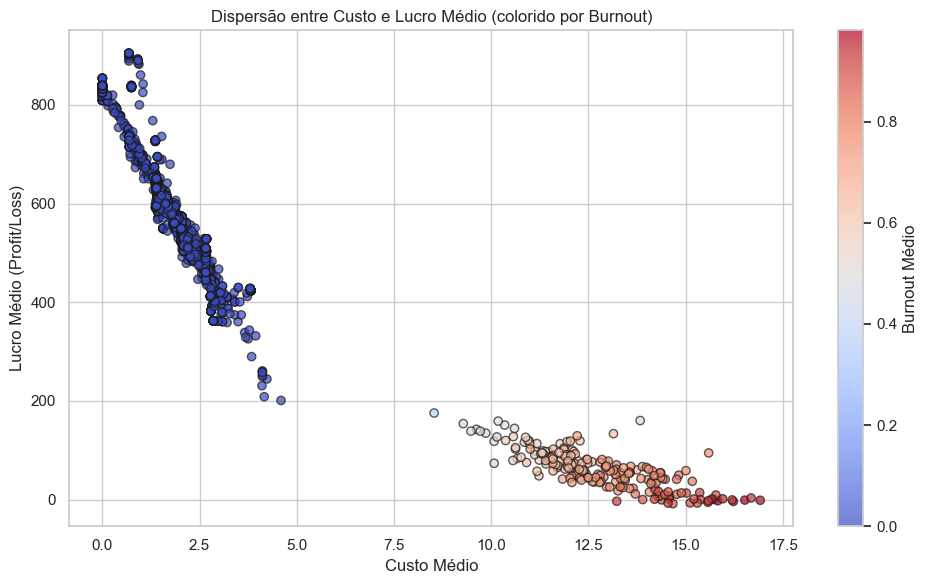

In [97]:
# Agrupamento por geração e blocos de 10 iterações
df['iteration_group'] = (df['iteration'] // 10) * 10

df_group = df.groupby(['generation', 'iteration_group']).agg({
    'cost': 'mean',
    'profit_loss': 'mean',
    'burnout': 'mean'  # só se quiser colorir com burnout
}).reset_index()

# Plot simples
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_group['cost'],
    df_group['profit_loss'],
    c=df_group['burnout'],  # cor opcional baseada no burnout médio
    cmap='coolwarm',
    alpha=0.7,
    edgecolors='k'
)

plt.xlabel("Custo Médio")
plt.ylabel("Lucro Médio (Profit/Loss)")
plt.title("Dispersão entre Custo e Lucro Médio (colorido por Burnout)")
cbar = plt.colorbar(scatter)
cbar.set_label('Burnout Médio')
plt.grid(True)
plt.tight_layout()
plt.savefig('evidencias-artigo/dispersao-custo-lucro-colorido-por-burnout', dpi=300)
plt.show()

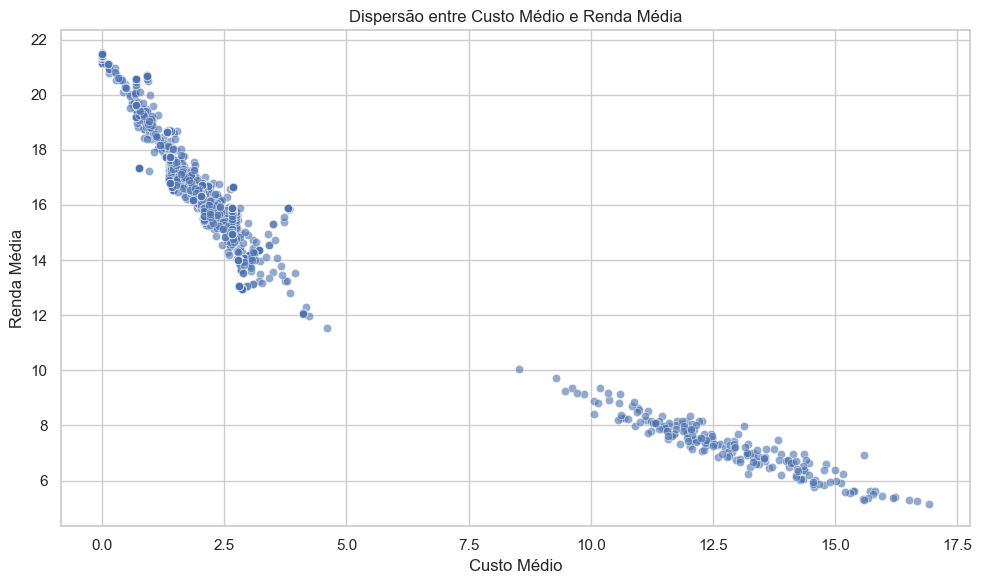

In [101]:
# Agrupar por geração + blocos de 10 iterações
df['iteration_group'] = (df['iteration'] // 10) * 10
df_grouped = df.groupby(['generation', 'iteration_group']).agg({
    'cost': 'mean',
    'income': 'mean'
}).reset_index()

# Gráfico de dispersão entre as médias
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_grouped, x='cost', y='income', alpha=0.6)

plt.title("Dispersão entre Custo Médio e Renda Média")
plt.xlabel("Custo Médio")
plt.ylabel("Renda Média")
plt.grid(True)
plt.tight_layout()
plt.savefig('evidencias-artigo/dispersao-custo-ganho', dpi=300)
plt.show()